## 1. 데이터 로드

In [1]:
import pandas as pd

# 파일 경로 지정
path_fee = "한국장학재단_대학별 평균등록금_20250519.csv"
path_scholarship = "한국장학재단_대학별 장학금 수혜 현황_20240831.csv"

# 데이터 불러오기
df_fee = pd.read_csv(path_fee, encoding="utf-8")
df_sch = pd.read_csv(path_scholarship, encoding="utf-8")

# 기본 확인
print("평균등록금 데이터:", df_fee.shape)
print(df_fee.head(), "\n")

print("장학금 수혜 현황 데이터:", df_sch.shape)
print(df_sch.head())

평균등록금 데이터: (383, 7)
  학제별  설립별      대학명 지역별   입학정원  평균입학금   평균등록금(원)
0  대학  국공립    강원대학교  강원  18175      0  4198744.0
1  대학  국공립    경북대학교  대구  20092      0  4514173.1
2  대학  국공립  경상국립대학교  경남  17578      0  4084328.8
3  대학  국공립  경인교육대학교  인천   2320      0  3492872.4
4  대학  국공립  공주교육대학교  충남   1375      0  3600000.0 

장학금 수혜 현황 데이터: (391, 17)
   조사연도  기준연도        학교명 설립별 지역별  교외장학금 소계(원)      교외장학금 국가  교외장학금 지방자치단체  \
0  2024  2023   ICT폴리텍대학  사립  경기    494292500  3.450500e+08           0.0   
1  2024  2023  가야대학교(김해)  사립  경남   4830697828  4.709586e+09     7876000.0   
2  2024  2023      가천대학교  사립  경기  41176426709  3.946661e+10    80007680.0   
3  2024  2023   가톨릭관동대학교  사립  강원  16619713888  1.580873e+10   562775810.0   
4  2024  2023  가톨릭꽃동네대학교  사립  충북   1654221901  1.545881e+09     1572960.0   

    교외장학금 사설및기타  교내장학금 소계(원)  교내장학금 성적우수장학금  교내장학금 저소득층장학금   교내장학금 근로장학금  \
0  1.492425e+08    167270000   2.856000e+07   1.387100e+08  0.000000e+00   
1  1.132360e+08   1893925885   5.029642e+08 

## 2. 환경 세팅

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 윈도우 기본 한글 폰트 지정
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [3]:
# --- Hangul font bullet-proof apply (Windows/mac/Linux 공통) ---
import os, glob, platform, warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

warnings.filterwarnings("ignore", message="Glyph .* missing from font")

# 1) 후보 폰트 파일 경로 (있는 것 하나만 잡아서 사용)
cands = [
    r"C:\Windows\Fonts\malgun.ttf",                 # Windows 맑은고딕 (보통)
    r"C:\Windows\Fonts\malgunbd.ttf",               # Windows 맑은고딕 (볼드)
    r"C:\Windows\Fonts\NanumGothic.ttf",            # Windows 나눔고딕
    "/System/Library/Fonts/AppleGothic.ttf",        # macOS
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # Linux
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",  # Linux (Noto)
]

font_path = next((p for p in cands if os.path.exists(p)), None)
if font_path is None:
    raise RuntimeError("한글 폰트 파일을 찾지 못했어요. Windows면 C:\\Windows\\Fonts\\malgun.ttf 존재 확인!")

# 2) 폰트 파일을 등록하고, 내부 폰트명을 정확히 얻어서 rc에 반영
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

# 3) Matplotlib + Seaborn 모두 동일 폰트로 고정
mpl.rcParams["font.family"] = [font_name]
mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False
sns.set_theme(style="whitegrid", font=font_name, rc={"axes.unicode_minus": False})

# 4) (옵션) 폰트 캐시가 꼬였을 수 있으니 목록만 정리
cache_dir = mpl.get_cachedir()
for f in glob.glob(os.path.join(cache_dir, "fontlist*")):
    try: os.remove(f)
    except: pass

print(f"[Font] Using '{font_name}' from: {font_path}")

'''
# 빠른 테스트
plt.figure()
plt.title("한글 폰트 테스트: 평균등록금/장학금 -1")
plt.xlabel("가로축 한글")
plt.ylabel("세로축 한글")
plt.plot([0,1],[0,-1])
plt.show()
'''

[Font] Using 'Malgun Gothic' from: C:\Windows\Fonts\malgun.ttf


'\n# 빠른 테스트\nplt.figure()\nplt.title("한글 폰트 테스트: 평균등록금/장학금 -1")\nplt.xlabel("가로축 한글")\nplt.ylabel("세로축 한글")\nplt.plot([0,1],[0,-1])\nplt.show()\n'

In [4]:
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']  # 대체 폰트도 함께
mpl.rcParams['axes.unicode_minus'] = False                      # 유니코드 마이너스 → ASCII
mpl.rcParams['mathtext.default'] = 'regular'                    # TeX 수식 폰트 섞임 방

## 3. 매칭 키 정규화 + 예외 매핑

In [5]:
import re
import pandas as pd

def clean_name(name: str) -> str:
    """대학/학교명 표준화: 괄호, 특수/제로폭 문자, 공백, 접두어 등 정리"""
    if pd.isna(name):
        return name
    x = str(name).strip()

    # 괄호와 괄호 내용 제거
    x = re.sub(r"\(.*?\)", "", x)

    # 제로폭/전각 공백 등 제거 및 공백 축소
    x = x.replace("\u200b", "").replace("\u200c", "").replace("\u3000", " ")
    x = re.sub(r"\s+", " ", x)

    # 접두어/표기 통일
    x = re.sub(r"^국립", "", x)        
    x = x.replace("대학교", "대학")      
    x = x.replace(" 캠퍼스", "캠퍼스")   

    return x.strip()

# 1) 표준화 컬럼 생성(원본 보존)
df_fee["대학명_clean"] = df_fee["대학명"].apply(clean_name)
df_sch["학교명_clean"] = df_sch["학교명"].apply(clean_name)

# 2) 예외 매핑(표기 변경/개명 등 수동 보정) — 필요 시 계속 추가
manual_map = {
}
df_fee["대학명_clean"] = df_fee["대학명_clean"].replace(manual_map)
df_sch["학교명_clean"] = df_sch["학교명_clean"].replace(manual_map)

# 3) 정규화 후 매칭률 확인
fee_names2 = set(df_fee["대학명_clean"].dropna().unique())
sch_names2 = set(df_sch["학교명_clean"].dropna().unique())
common2 = fee_names2 & sch_names2

print("정규화 후 겹치는 대학 개수:", len(common2))
print("총 대학수 (fee):", len(fee_names2), " (sch):", len(sch_names2))

only_in_fee2 = sorted(list(fee_names2 - sch_names2))[:10]
only_in_sch2 = sorted(list(sch_names2 - fee_names2))[:10]
print("\n여전히 fee에만 있는 대학 예시:", only_in_fee2)
print("\n여전히 sch에만 있는 대학 예시:", only_in_sch2)

정규화 후 겹치는 대학 개수: 378
총 대학수 (fee): 383  (sch): 386

여전히 fee에만 있는 대학 예시: ['경국대학', '서라벌대학', '인천재능대학', '한국골프과학기술대학', '한국폴리텍 II 대학 화성캠퍼스']

여전히 sch에만 있는 대학 예시: ['경남과학기술대학', '상지영서대학', '안동대학', '재능대학', '태재대학', '한국골프대학', '한국폴리텍 V 대학 순천캠퍼스', '한국폴리텍 VII 대학 진주캠퍼스']


## 4. 보강 매핑 + 유사 후보 뽑기

In [6]:
import difflib

# 1) 잔여 케이스를 반영해 보강 매핑(정책에 맞게 수정 가능)
manual_map_boost = {
    "재능대학": "인천재능대학",
    "한국골프대학": "한국골프과학기술대학",
}
df_fee["대학명_clean"] = df_fee["대학명_clean"].replace(manual_map_boost)
df_sch["학교명_clean"] = df_sch["학교명_clean"].replace(manual_map_boost)

# 2) 재계산
fee_set = set(df_fee["대학명_clean"].dropna().unique())
sch_set = set(df_sch["학교명_clean"].dropna().unique())
common = fee_set & sch_set
only_fee = sorted(list(fee_set - sch_set))
only_sch = sorted(list(sch_set - fee_set))

print("▶ 재매칭 결과 — 겹치는 대학:", len(common), "/ fee:", len(fee_set), "/ sch:", len(sch_set))
print("\n여전히 fee-only 예시:", only_fee[:10])
print("여전히 sch-only 예시:", only_sch[:10])

# 3) 유사 후보 추천(각 5개) — 수동 매핑 후보군 만들기
def suggest(part, pool, n=5):
    out = []
    for p in part[:10]:  # 상위 10개만 샘플
        cands = difflib.get_close_matches(p, pool, n=n, cutoff=0)
        out.append((p, cands))
    return out

print("\n[유사 후보] fee-only → sch 후보")
for name, cands in suggest(only_fee, list(sch_set)):
    print(f" - {name:>25}  =>  {cands}")

print("\n[유사 후보] sch-only → fee 후보")
for name, cands in suggest(only_sch, list(fee_set)):
    print(f" - {name:>25}  =>  {cands}")

▶ 재매칭 결과 — 겹치는 대학: 380 / fee: 383 / sch: 386

여전히 fee-only 예시: ['경국대학', '서라벌대학', '한국폴리텍 II 대학 화성캠퍼스']
여전히 sch-only 예시: ['경남과학기술대학', '상지영서대학', '안동대학', '태재대학', '한국폴리텍 V 대학 순천캠퍼스', '한국폴리텍 VII 대학 진주캠퍼스']

[유사 후보] fee-only → sch 후보
 -                      경국대학  =>  ['한경국립대학', '경상국립대학', '세경대학', '서경대학', '부경대학']
 -                     서라벌대학  =>  ['호서대학', '한서대학', '한라대학', '신라대학', '서정대학']
 -         한국폴리텍 II 대학 화성캠퍼스  =>  ['한국폴리텍 I 대학 성남캠퍼스', '한국폴리텍 II 대학 인천캠퍼스', '한국폴리텍 VII 대학 창원캠퍼스', '한국폴리텍 VII 대학 진주캠퍼스', '한국폴리텍 VII 대학 울산캠퍼스']

[유사 후보] sch-only → fee 후보
 -                  경남과학기술대학  =>  ['경기과학기술대학', '서울과학기술대학', '부산과학기술대학', '동원과학기술대학', '대전과학기술대학']
 -                    상지영서대학  =>  ['상지대학', '가톨릭상지대학', '호서대학', '한영대학', '한서대학']
 -                      안동대학  =>  ['안동과학대학', '한동대학', '장안대학', '안양대학', '안산대학']
 -                      태재대학  =>  ['배재대학', '인천재능대학', '홍익대학', '호원대학', '호서대학']
 -          한국폴리텍 V 대학 순천캠퍼스  =>  ['한국폴리텍 V 대학 전북캠퍼스', '한국폴리텍 V 대학 전남캠퍼스', '한국폴리텍 V 대학 익산캠퍼스', '한국폴리텍 V 대학 광주캠퍼스', '한국폴리텍 V

## 5. 병합 정책 확정 + master 생성

In [7]:
import numpy as np
import pandas as pd

manual_map_final = {
}
if len(manual_map_final):
    df_fee["대학명_clean"] = df_fee["대학명_clean"].replace(manual_map_final)
    df_sch["학교명_clean"] = df_sch["학교명_clean"].replace(manual_map_final)

# --- 1) 슬림 테이블 생성 (집계 규칙 포함) ---
fee_agg = {
    "평균등록금(원)": "mean",
    "평균입학금": "mean",
    "입학정원": "max",     
    "설립별": "first",
    "지역별": "first",
}
sch_agg = {
    "교외장학금 소계(원)": "sum",
    "교내장학금 소계(원)": "sum",
    "총계(원)": "sum",
    "학제별": "first",
}

fee_slim = (
    df_fee
    .rename(columns={"대학명_clean": "대학키"})
    .groupby("대학키", as_index=False)
    .agg({k:v for k,v in fee_agg.items() if k in df_fee.columns})
)

sch_slim = (
    df_sch
    .rename(columns={"학교명_clean": "대학키"})
    .groupby("대학키", as_index=False)
    .agg({k:v for k,v in sch_agg.items() if k in df_sch.columns})
)

print("fee_slim:", fee_slim.shape, " / sch_slim:", sch_slim.shape)

# --- 2) 병합: 기본 inner + 감사용 outer ---
master = pd.merge(fee_slim, sch_slim, on="대학키", how="inner")
print("master (inner merge):", master.shape)
display(master.head(3))

audit = pd.merge(fee_slim.assign(src="fee"),
                 sch_slim.assign(src="sch"),
                 on="대학키", how="outer", indicator=True,
                 suffixes=("_fee","_sch"))
# 감사표 요약
audit["_where"] = audit["_merge"].map({"left_only":"fee_only","right_only":"sch_only","both":"both"})
print("\n[감사표 요약]")
print(audit["_where"].value_counts())
# 저장
audit.to_csv("unmatched_audit.csv", index=False, encoding="utf-8-sig")

# --- 3) 파생 변수 생성 ---
# 숫자화 안전 처리
for c in ["평균등록금(원)","입학정원","총계(원)","교외장학금 소계(원)","교내장학금 소계(원)"]:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors="coerce")

# 파생
eps = 1e-9
if set(["총계(원)","평균등록금(원)"]).issubset(master.columns):
    master["장학금_등록금대비"] = master["총계(원)"] / (master["평균등록금(원)"] + eps)
if set(["총계(원)","평균등록금(원)","입학정원"]).issubset(master.columns):
    master["장학금_등록금x정원_비율"] = master["총계(원)"] / ((master["평균등록금(원)"] * master["입학정원"]) + eps)
if set(["총계(원)","교외장학금 소계(원)","교내장학금 소계(원)"]).issubset(master.columns):
    master["교외비중"] = master["교외장학금 소계(원)"] / (master["총계(원)"] + eps)
    master["교내비중"] = master["교내장학금 소계(원)"] / (master["총계(원)"] + eps)

# --- 4) 저장 ---
master.to_csv("master_univ.csv", index=False, encoding="utf-8-sig")
print("\n저장 완료 → master_univ.csv, unmatched_audit.csv")

fee_slim: (383, 6)  / sch_slim: (386, 4)
master (inner merge): (380, 9)


,대학키,평균등록금(원),평균입학금,입학정원,설립별,지역별,교외장학금 소계(원),교내장학금 소계(원),총계(원)
0,ICT폴리텍대학,2500000.0,0.0,320,사립,경기,494292500,167270000,661562500
1,가야대학,7239309.3,0.0,1765,사립,경남,4830697828,1893925885,6724623713
2,가천대학,8812617.8,0.0,16724,사립,경기,41176426709,28576487725,69752914434



[감사표 요약]
_where
both        380
sch_only      6
fee_only      3
Name: count, dtype: int64

저장 완료 → master_univ.csv, unmatched_audit.csv


## 6. 데이터 품질 검증 + EDA

[Font] Using: Malgun Gothic
행/열: (380, 16)

[결측치 개수 상위]


대학키            0
평균등록금(원)       0
평균입학금          0
입학정원           0
설립별            0
지역별            0
교외장학금 소계(원)    0
교내장학금 소계(원)    0
총계(원)          0
장학금_등록금대비      0
dtype: int64


[금액/정원 컬럼의 0값 개수]
평균입학금          380
평균등록금(원)         4
교내장학금 소계(원)      4
교외장학금 소계(원)      3
총계(원)            3
입학정원             1
dtype: int64

[숫자열 요약 통계]


,count,mean,std,min,25%,50%,75%,max
평균등록금(원),380.0,5.946212e+06,2.112941e+06,0.0,4.361598e+06,6.535629e+06,7.541324e+06,9.600692e+06
총계(원),380.0,1.722336e+10,1.837525e+10,0.0,3.622343e+09,1.133807e+10,2.426275e+10,9.813150e+10
입학정원,380.0,5.166061e+03,1.287020e+04,0.0,1.120750e+03,3.088000e+03,6.183500e+03,2.385600e+05
장학금_등록금대비,380.0,4.951316e+14,9.651891e+15,0.0,7.796820e+02,1.845106e+03,3.703922e+03,1.881500e+17
장학금_등록금x정원_비율,380.0,4.951316e+14,9.651891e+15,0.0,4.934632e-01,5.997248e-01,7.250456e-01,1.881500e+17
교외비중,380.0,7.015468e-01,1.514786e-01,0.0,6.664164e-01,7.366460e-01,7.871727e-01,1.000000e+00
교내비중,380.0,2.905584e-01,1.403302e-01,0.0,2.105807e-01,2.621765e-01,3.299500e-01,9.766623e-01
log_평균등록금(원),380.0,1.536635e+01,1.645144e+00,0.0,1.528830e+01,1.569278e+01,1.583591e+01,1.607735e+01
log_총계(원),380.0,2.267854e+01,2.506646e+00,0.0,2.201039e+01,2.315142e+01,2.391221e+01,2.530957e+01
log_입학정원,380.0,7.826606e+00,1.322426e+00,0.0,7.022624e+00,8.035599e+00,8.729801e+00,1.238238e+01


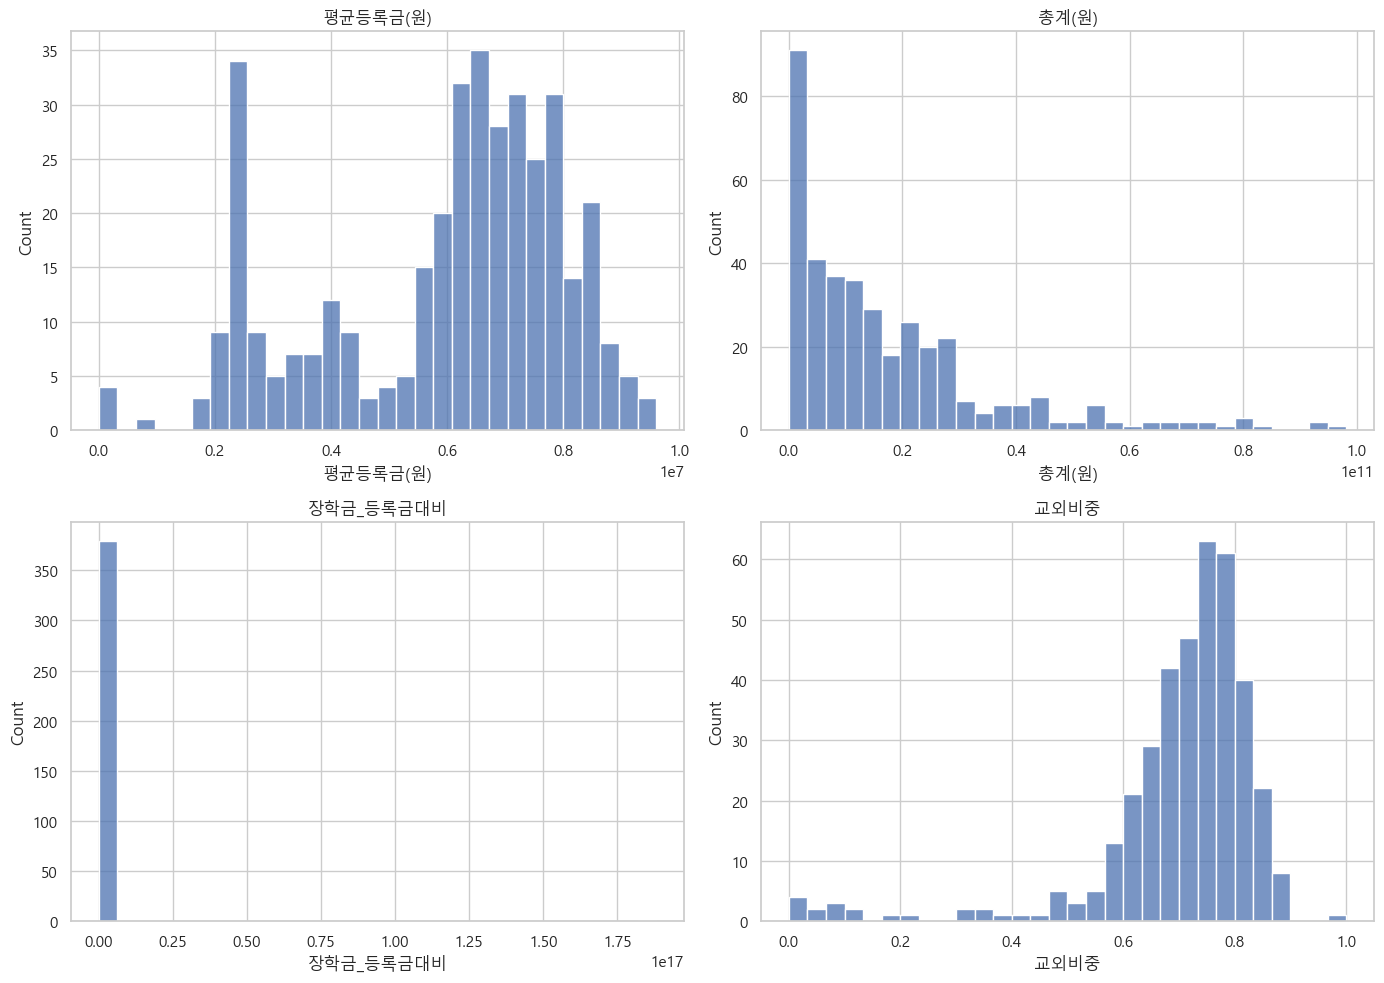

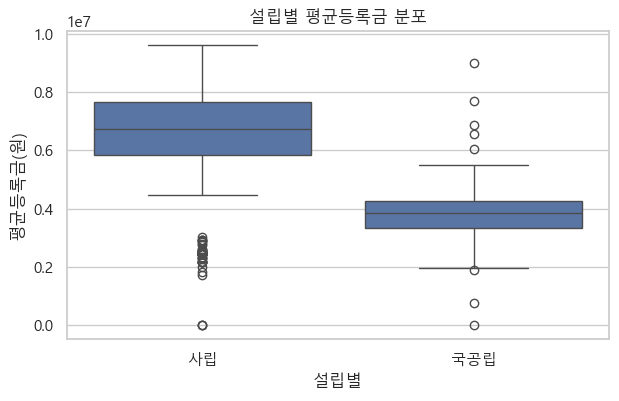

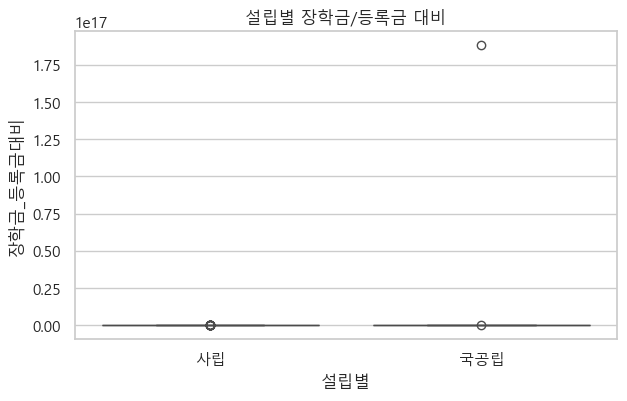

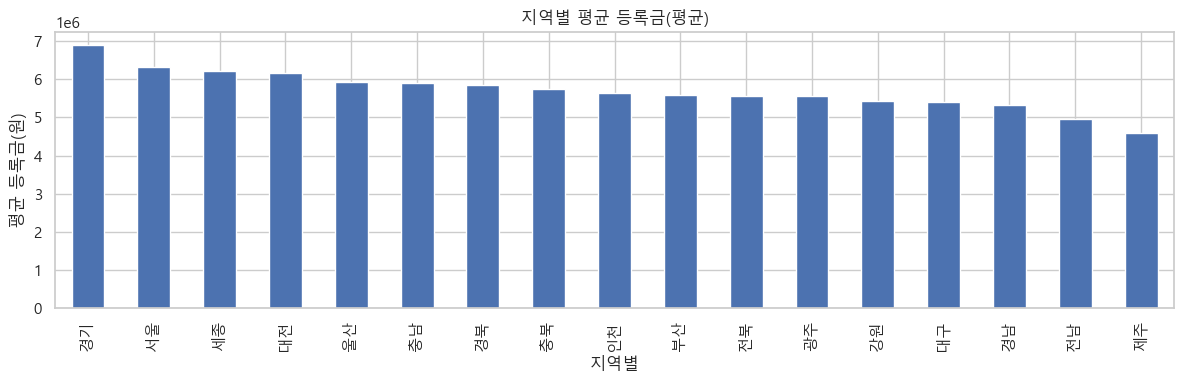

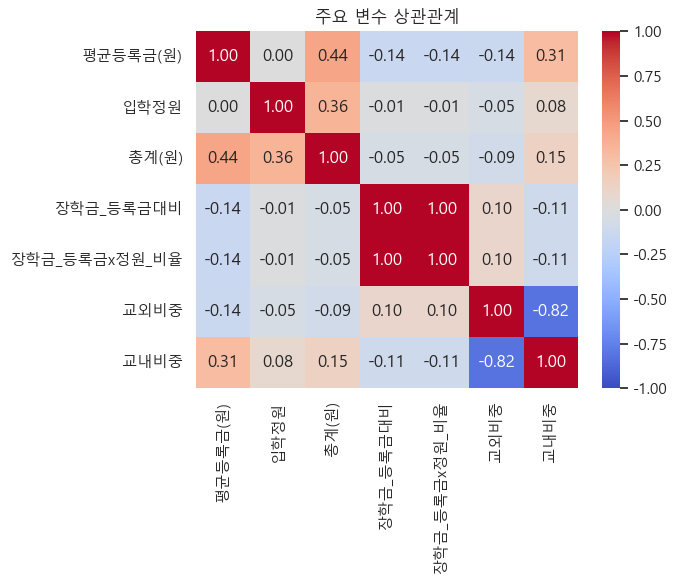

저장 완료 → master_univ_enriched.csv


In [8]:
import os, platform, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

warnings.filterwarnings("ignore", message="Glyph .* missing from font")

# ---- (A) 한글 폰트 강제 적용 ----
def set_korean_font():
    sys = platform.system()
    if sys == "Windows":
        cands = [
            r"C:\Windows\Fonts\malgun.ttf",
            r"C:\Windows\Fonts\malgunbd.ttf",
            r"C:\Windows\Fonts\NanumGothic.ttf",
        ]
    elif sys == "Darwin":  # macOS
        cands = ["/System/Library/Fonts/AppleGothic.ttf"]
    else:  # Linux
        cands = [
            "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
            "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
            "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        ]

    font_path = next((p for p in cands if os.path.exists(p)), None)
    if font_path:
        fm.fontManager.addfont(font_path)
        font_name = fm.FontProperties(fname=font_path).get_name()
    else:
        font_name = "DejaVu Sans"  # 최후 폴백

    # Matplotlib + Seaborn 모두 동일 폰트로 고정
    mpl.rcParams.update({
        "font.family": [font_name],
        "font.sans-serif": [font_name],
        "axes.unicode_minus": False,
    })
    sns.set_theme(style="whitegrid", font=font_name, rc={"axes.unicode_minus": False})
    print(f"[Font] Using: {font_name}")

set_korean_font()

# ---- (B) master 로드(이미 있으면 사용) ----
if "master" not in globals():
    # 직전 단계에서 저장한 파일명이 다르면 수정
    if os.path.exists("master_univ.csv"):
        master = pd.read_csv("master_univ.csv", encoding="utf-8")
    else:
        raise RuntimeError("master DataFrame이 메모리에 없고 master_univ.csv도 찾지 못했어요.")

# ---- (C) 숫자형 컬럼 안전 변환 ----
num_cols_base = [
    "평균등록금(원)", "평균입학금", "입학정원",
    "교외장학금 소계(원)", "교내장학금 소계(원)", "총계(원)"
]
for c in num_cols_base:
    if c in master.columns:
        master[c] = pd.to_numeric(master[c], errors="coerce")

# 파생(있으면 덮어씀)
eps = 1e-9
if {"총계(원)","평균등록금(원)"}.issubset(master.columns):
    master["장학금_등록금대비"] = master["총계(원)"] / (master["평균등록금(원)"] + eps)
if {"총계(원)","평균등록금(원)","입학정원"}.issubset(master.columns):
    master["장학금_등록금x정원_비율"] = master["총계(원)"] / ((master["평균등록금(원)"] * master["입학정원"]) + eps)
if {"총계(원)","교외장학금 소계(원)","교내장학금 소계(원)"}.issubset(master.columns):
    master["교외비중"] = master["교외장학금 소계(원)"] / (master["총계(원)"] + eps)
    master["교내비중"] = master["교내장학금 소계(원)"] / (master["총계(원)"] + eps)

# 로그 보조 지표
for c in ["평균등록금(원)","총계(원)","입학정원"]:
    if c in master.columns:
        master[f"log_{c}"] = np.log1p(master[c])

# ---- (D) 품질 점검 ----
print("행/열:", master.shape)
nulls = master.isna().sum().sort_values(ascending=False)
zeros = {c: int((master[c]==0).sum()) for c in num_cols_base if c in master.columns}

print("\n[결측치 개수 상위]")
display(nulls.head(10))
print("\n[금액/정원 컬럼의 0값 개수]")
print(pd.Series(zeros).sort_values(ascending=False))

# 숫자열 요약
num_cols_view = [c for c in [
    "평균등록금(원)","총계(원)","입학정원",
    "장학금_등록금대비","장학금_등록금x정원_비율","교외비중","교내비중",
    "log_평균등록금(원)","log_총계(원)","log_입학정원"
] if c in master.columns]
print("\n[숫자열 요약 통계]")
if num_cols_view:
    display(master[num_cols_view].describe().T)

# ---- (E) 분포 그림 ----
fig, axes = plt.subplots(2,2, figsize=(14,10))
ax = axes.ravel()

def hist(ax, col, bins=30):
    sns.histplot(master[col].dropna(), bins=bins, ax=ax)
    ax.set_title(col)

plot_cols = [c for c in ["평균등록금(원)","총계(원)","장학금_등록금대비","교외비중"] if c in master.columns]
for i, col in enumerate(plot_cols):
    hist(ax[i], col)
for j in range(len(plot_cols), 4):
    ax[j].axis("off")
plt.tight_layout()
plt.show()

# ---- (F) 설립/지역별 비교 ----
if "설립별" in master.columns and "평균등록금(원)" in master.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=master, x="설립별", y="평균등록금(원)")
    plt.title("설립별 평균등록금 분포")
    plt.show()

if "설립별" in master.columns and "장학금_등록금대비" in master.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=master, x="설립별", y="장학금_등록금대비")
    plt.title("설립별 장학금/등록금 대비")
    plt.show()

if "지역별" in master.columns and "평균등록금(원)" in master.columns:
    plt.figure(figsize=(12,4))
    (master.groupby("지역별")["평균등록금(원)"]
           .mean().sort_values(ascending=False)
           .plot(kind="bar"))
    plt.ylabel("평균 등록금(원)")
    plt.title("지역별 평균 등록금(평균)")
    plt.tight_layout()
    plt.show()

# ---- (G) 상관행렬 ----
corr_cols = [c for c in [
    "평균등록금(원)","입학정원","총계(원)",
    "장학금_등록금대비","장학금_등록금x정원_비율","교외비중","교내비중"
] if c in master.columns]
if len(corr_cols) >= 2:
    plt.figure(figsize=(7,6))
    corr = master[corr_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("주요 변수 상관관계")
    plt.tight_layout()
    plt.show()

# ---- (H) 저장 ----
master.to_csv("master_univ_enriched.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → master_univ_enriched.csv")

## 7. 0값/이상치 안전 처리 + 불균형(Entropy/Gini) 계산 + 위험라벨 생성

In [9]:
import numpy as np
import pandas as pd

df = master.copy()

# 숫자형 캐스팅(안전)
for c in ["평균등록금(원)", "입학정원", "총계(원)", "교외장학금 소계(원)", "교내장학금 소계(원)"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 4-1) 안전한 비율 계산
def safe_div(num, den):
    num = np.asarray(num, dtype="float64")
    den = np.asarray(den, dtype="float64")
    out = np.full_like(num, np.nan, dtype="float64")
    ok = (den > 0) & np.isfinite(den) & np.isfinite(num)
    out[ok] = num[ok] / den[ok]
    return out

# 핵심 비율/규모 파생
if {"총계(원)","입학정원"}.issubset(df.columns):
    df["장학금_정원당"] = safe_div(df["총계(원)"], df["입학정원"])

if {"총계(원)","평균등록금(원)"}.issubset(df.columns):
    df["장학금_등록금대비"] = safe_div(df["총계(원)"], df["평균등록금(원)"])

# Winsorize(1%~99%) 보조열
for c in ["장학금_정원당", "장학금_등록금대비"]:
    if c in df.columns:
        lo, hi = df[c].quantile([0.01, 0.99])
        df[c+"_clip"] = df[c].clip(lower=lo, upper=hi)

# 4-2) 교외/교내 비중 재계산(정규화)
ext = df["교외장학금 소계(원)"].fillna(0)
intv = df["교내장학금 소계(원)"].fillna(0)
tot  = (ext + intv)

# tot=0이면 NaN 처리하여 비중이 잘못 생기지 않도록
tot = tot.where(tot > 0, np.nan)
df["교외비중"] = ext / tot
df["교내비중"] = intv / tot

# 4-3) 불균형 지수(Entropy, Gini)
def entropy_norm(p):
    """p: 확률 벡터(합=1). 정규화 엔트로피(0~1)."""
    p = np.asarray(p, dtype="float64")
    p = p[(p > 0) & np.isfinite(p)]
    if p.size == 0:
        return np.nan
    H = -np.sum(p * np.log(p))
    return H / np.log(len(p))

def gini_from_amounts(v):
    """양수 금액 벡터로 Gini(0~1)."""
    v = np.asarray(v, dtype="float64")
    v = v[(v >= 0) & np.isfinite(v)]
    s = v.sum()
    if v.size == 0 or s == 0:
        return np.nan
    v = np.sort(v)
    n = v.size
    cum = np.cumsum(v)
    # 1 + 1/n - 2 * (∑ cum_i) / (n * sum)
    return 1 + 1/n - 2 * np.sum(cum) / (n * s)

# 두 성분(교외/교내) 기준으로 엔트로피/Gini
df["불균형_Entropy"] = [
    entropy_norm(np.array([a, b])/(a+b) if (a+b)>0 else np.array([]))
    for a, b in zip(ext, intv)
]
df["불균형_Gini"] = [gini_from_amounts(np.array([a, b])) for a, b in zip(ext, intv)]

# 4-4) 위험라벨: Gini 상위 20%
thr = np.nanpercentile(df["불균형_Gini"].dropna(), 80)
df["위험군"] = (df["불균형_Gini"] >= thr).astype(int)

print(f"Gini 상위 20% 기준값: {thr:.3f}")
print(f"위험군 대학 수: {int(df['위험군'].sum())} / {df['위험군'].notna().sum()}")

# 점검용 미리보기(상위 8개)
preview_cols = ["대학키","설립별","지역별","평균등록금(원)","총계(원)",
                "교외비중","교내비중","불균형_Gini","불균형_Entropy","위험군"]
display(df[preview_cols].sort_values("불균형_Gini", ascending=False).head(8))

# master 갱신 & 저장
master = df.copy()
master.to_csv("master_with_indices.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → master_with_indices.csv")

Gini 상위 20% 기준값: 0.303
위험군 대학 수: 76 / 380


C:\Users\jso25\AppData\Local\Temp\ipykernel_2784\4185897081.py:51: RuntimeWarning: invalid value encountered in scalar divide
  return H / np.log(len(p))


,대학키,설립별,지역별,평균등록금(원),총계(원),교외비중,교내비중,불균형_Gini,불균형_Entropy,위험군
310,한국농수산대학,국공립,전북,0.0,188150000,1.000000,0.000000,0.500000,NaN,1
237,웅지세무대학,사립,경기,6960000.0,629024000,0.023338,0.976662,0.476662,0.159792,1
312,한국복지대학,국공립,경기,2714000.0,233499817,0.053813,0.946187,0.446187,0.302379,1
74,나주대학,사립,전남,4603038.8,3752575125,0.063635,0.936365,0.436365,0.341708,1
378,화성의과학대학,사립,경기,7704138.4,404813710,0.073767,0.926233,0.426233,0.379828,1
81,대구경북과학기술원,국공립,대구,7690000.0,2292368475,0.078709,0.921291,0.421291,0.397614,1
316,한국에너지공과대학,국공립,전남,9000000.0,2985700000,0.083866,0.916134,0.416134,0.415658,1
323,한국침례신학대학,사립,대전,6164013.7,5378165755,0.899113,0.100887,0.399113,0.471800,1


저장 완료 → master_with_indices.csv


## 8. 경고 패치 + “위험군 vs 비위험군” 비교 스냅샷


[중앙값 비교] 위험군 vs 비위험군


,평균등록금(원),총계(원),장학금_정원당_clip,장학금_등록금대비_clip,교외비중,교내비중,불균형_Gini,불균형_Entropy
위험군,,,,,,,,
비위험군,6812691.00,1.534095e+10,3.846688e+06,2415.451325,0.717142,0.282858,0.217417,0.857728
위험군,4724961.55,3.034694e+09,2.828954e+06,605.857325,0.824859,0.175141,0.334848,0.646492


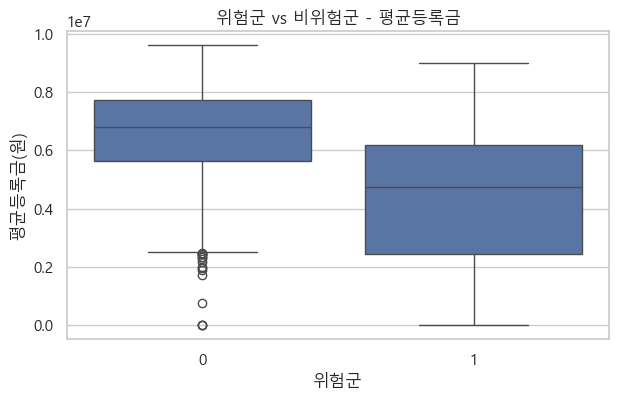

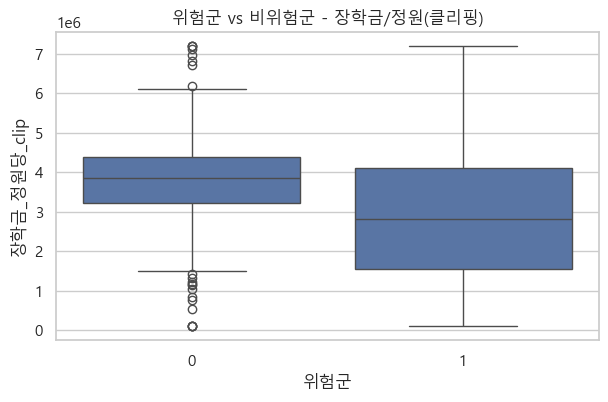

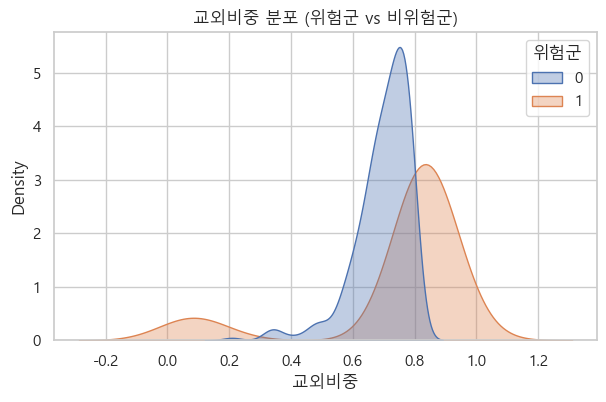


[설립별 위험비율(%)]


,위험비율(%)
설립별,
사립,20.6
국공립,16.4



[지역별 위험비율(%) TOP 10]


,위험비율(%)
지역별,
세종,50.0
울산,40.0
제주,40.0
전남,40.0
광주,33.3
대전,29.4
대구,28.6
경북,28.6
강원,27.8


저장 완료 → risk_snapshot.csv


In [10]:
# ===== [셀] 엔트로피 경고 패치 + 위험군 vs 비위험군 비교 =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

sns.set_theme(style="whitegrid", rc={"font.family": "Malgun Gothic", "axes.unicode_minus": False})
rcParams.update({"font.family": "Malgun Gothic", "axes.unicode_minus": False})

df = master.copy()

# ---- 1) 엔트로피 패치(성분 수 <= 1이면 0으로 간주: 완전 편중) ----
def entropy_norm_safe(a, b):
    v = np.asarray([a, b], dtype="float64")
    v = v[(v > 0) & np.isfinite(v)]
    n = v.size
    if n <= 1:
        return 0.0
    p = v / v.sum()
    H = -np.sum(p * np.log(p))
    return H / np.log(n)

df["불균형_Entropy"] = [
    entropy_norm_safe(a, b)
    for a, b in zip(df["교외장학금 소계(원)"].fillna(0), df["교내장학금 소계(원)"].fillna(0))
]

# ---- 2) 비교에 쓸 파생 보강 ----
def safe_div(num, den):
    num = np.asarray(num, dtype="float64")
    den = np.asarray(den, dtype="float64")
    out = np.full_like(num, np.nan, dtype="float64")
    ok = (den > 0) & np.isfinite(den) & np.isfinite(num)
    out[ok] = num[ok] / den[ok]
    return out

if {"총계(원)","입학정원"}.issubset(df.columns):
    df["장학금_정원당"] = safe_div(df["총계(원)"], df["입학정원"])
if {"총계(원)","평균등록금(원)"}.issubset(df.columns):
    df["장학금_등록금대비"] = safe_div(df["총계(원)"], df["평균등록금(원)"])

for c in ["장학금_정원당","장학금_등록금대비"]:
    if c in df.columns:
        lo, hi = df[c].quantile([0.01, 0.99])
        df[c + "_clip"] = df[c].clip(lo, hi)

# ---- 3) 위험군 vs 비위험군: 요약 표 ----
view_cols = [c for c in [
    "평균등록금(원)","총계(원)","장학금_정원당_clip","장학금_등록금대비_clip","교외비중","교내비중","불균형_Gini","불균형_Entropy"
] if c in df.columns]

summary = df.groupby("위험군")[view_cols].median().rename(index={0:"비위험군",1:"위험군"})
print("\n[중앙값 비교] 위험군 vs 비위험군")
display(summary)

# ---- 4) 시각화: 박스플롯/히스토 ----
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x="위험군", y="평균등록금(원)")
plt.title("위험군 vs 비위험군 - 평균등록금")
plt.show()

if "장학금_정원당_clip" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="위험군", y="장학금_정원당_clip")
    plt.title("위험군 vs 비위험군 - 장학금/정원(클리핑)")
    plt.show()

plt.figure(figsize=(7,4))
sns.kdeplot(data=df, x="교외비중", hue="위험군", common_norm=False, fill=True, alpha=0.35)
plt.title("교외비중 분포 (위험군 vs 비위험군)")
plt.show()

# ---- 5) 설립/지역별 위험비율 ----
by_found = (df.groupby("설립별")["위험군"].mean()*100).sort_values(ascending=False).round(1)
by_region = (df.groupby("지역별")["위험군"].mean()*100).sort_values(ascending=False).round(1)

print("\n[설립별 위험비율(%)]")
display(by_found.to_frame("위험비율(%)"))

print("\n[지역별 위험비율(%) TOP 10]")
display(by_region.head(10).to_frame("위험비율(%)"))

# ---- 6) 스냅샷 저장 ----
snap_cols = [c for c in ["대학키","설립별","지역별","평균등록금(원)","총계(원)","교외비중","교내비중","불균형_Gini","불균형_Entropy","위험군"] if c in df.columns]
df[snap_cols].to_csv("risk_snapshot.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → risk_snapshot.csv")

# master 갱신
master = df.copy()

## 9. 분석 신뢰도를 위해 통계적 유의성 검정 + 신뢰구간 시각화

In [11]:
# === 한글 폰트 완전 고정 패치 (셀 한 번 실행) ===
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm

def _pick_font_path():
    # OS별 후보 경로
    candidates = [
        r"C:\Windows\Fonts\malgun.ttf",          # Windows Malgun
        r"C:\Windows\Fonts\NanumGothic.ttf",     # Windows Nanum
        "/System/Library/Fonts/AppleGothic.ttf", # macOS
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # Linux
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

# 1) 시스템 폰트 파일을 직접 등록하고 전역 rc에 반영
FONT_PATH = _pick_font_path()
if FONT_PATH:
    fm.fontManager.addfont(FONT_PATH)
    FONT_NAME = fm.FontProperties(fname=FONT_PATH).get_name()
else:
    FONT_NAME = "DejaVu Sans"  # 최후 fallback

mpl.rcParams.update({
    "font.family": FONT_NAME,
    "font.sans-serif": [FONT_NAME],
    "axes.unicode_minus": False,
})
sns.set_theme(style="whitegrid",
              rc={"font.family": FONT_NAME, "axes.unicode_minus": False})

print(f"[Font Locked] {FONT_NAME}  ->  {FONT_PATH}")

# 2) 이미 만들어진 축에도 한글 폰트를 '강제로' 다시 입히는 헬퍼
from matplotlib.font_manager import FontProperties
_FP = FontProperties(fname=FONT_PATH) if FONT_PATH else None

def apply_korean(ax):
    """현재 축(ax) 안의 제목/라벨/틱까지 폰트를 강제로 교체"""
    if _FP is None:
        return
    ax.title.set_fontproperties(_FP)
    ax.xaxis.label.set_fontproperties(_FP)
    ax.yaxis.label.set_fontproperties(_FP)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontproperties(_FP)

def apply_korean_to_fig(fig=None):
    """현재 figure의 모든 axes에 일괄 적용"""
    fig = fig or plt.gcf()
    for ax in fig.axes:
        apply_korean(ax)

[Font Locked] Malgun Gothic  ->  C:\Windows\Fonts\malgun.ttf



[수치형: Mann–Whitney U + Cliff's delta]


,변수,비위험군_중앙값,위험군_중앙값,CliffsΔ(위험-비위험),p값
6,불균형_Gini,2.174166e-01,3.348482e-01,-1.000000,2.234873e-41
7,불균형_Entropy,8.577285e-01,6.464919e-01,0.980393,6.481718e-40
4,교외비중,7.171423e-01,8.248595e-01,-0.763158,8.459854e-25
5,교내비중,2.828577e-01,1.751405e-01,0.763158,8.459854e-25
1,총계(원),1.534095e+10,3.034694e+09,0.607341,2.588071e-16
0,평균등록금(원),6.812691e+06,4.724962e+06,0.558648,4.899780e-14
3,장학금_등록금대비_clip,2.415451e+03,6.058573e+02,0.536434,6.513827e-13
2,장학금_정원당_clip,3.846688e+06,2.828954e+06,0.316962,1.927569e-05



[설립별 카이제곱] chi2=0.299, p=0.5845


,표본수,위험비율
설립별,,
사립,325,0.206154
국공립,55,0.163636



[지역별 카이제곱(n≥10만)] chi2=25.880, p=0.0112


,표본수,위험비율
지역별,,
전남,20,0.400000
광주,18,0.333333
대전,17,0.294118
경북,35,0.285714
대구,14,0.285714
강원,18,0.277778
전북,21,0.238095
부산,26,0.230769
경남,20,0.200000


C:\Users\jso25\AppData\Local\Temp\ipykernel_2784\2390092703.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(viz["지역별"], rotation=45, ha="right")


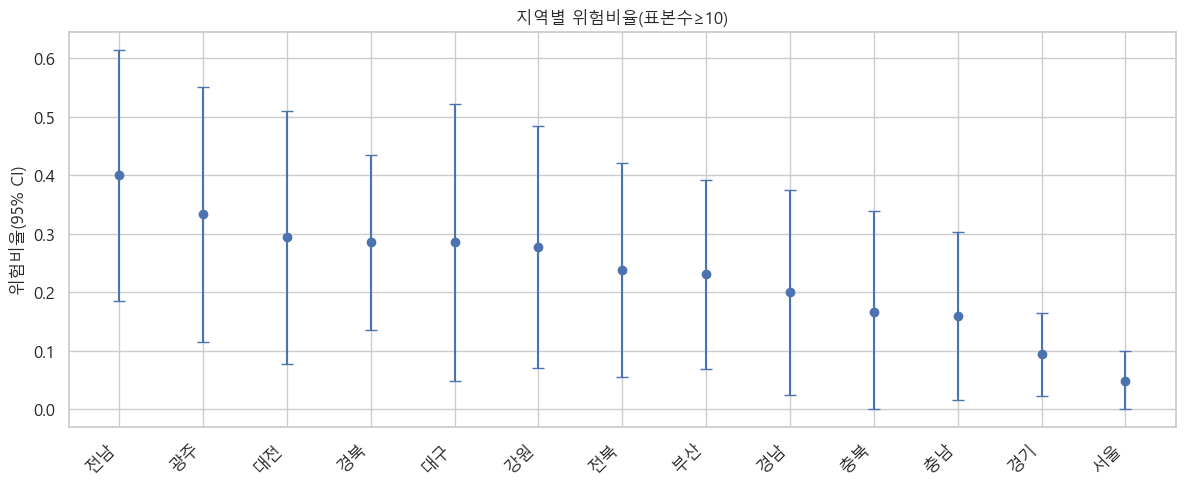

In [12]:
# === 통계 검정 + 신뢰구간 시각화 (Risk vs Non-risk) ===
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency

# [중요] seaborn이 폰트를 초기화하지 못하게 theme에서 rc로 다시 고정
sns.set_theme(style="whitegrid",
              rc={"font.family": mpl.rcParams["font.family"],
                  "axes.unicode_minus": False})

# 0) 안전 패치: Entropy NaN -> 0 (완전 편중이면 이론적으로 0)
if "불균형_Entropy" in master.columns:
    master["불균형_Entropy"] = master["불균형_Entropy"].fillna(0.0)

# 1) 수치형: Mann–Whitney U + Cliff's delta
num_targets = [
    c for c in ["평균등록금(원)","총계(원)","장학금_정원당_clip",
                "장학금_등록금대비_clip","교외비중","교내비중",
                "불균형_Gini","불균형_Entropy"]
    if c in master.columns
]

def cliffs_delta(a, b):
    # A=비위험(0), B=위험(1) 순서로 넣으면 음수는 위험군이 더 작다는 뜻
    a = np.asarray(a); b = np.asarray(b)
    n1, n2 = len(a), len(b)
    gt = sum(x > y for x in a for y in b)
    lt = sum(x < y for x in a for y in b)
    return (gt - lt) / (n1*n2)

rows = []
g0 = master[master["위험군"]==0]
g1 = master[master["위험군"]==1]
for c in num_targets:
    a, b = g0[c].dropna(), g1[c].dropna()
    if len(a)>0 and len(b)>0:
        stat, p = mannwhitneyu(a, b, alternative="two-sided")
        delta = cliffs_delta(a, b)  # 음수면 위험군<비위험군
        rows.append([c, a.median(), b.median(), delta, p])

num_test = (pd.DataFrame(rows, columns=["변수","비위험군_중앙값","위험군_중앙값","CliffsΔ(위험-비위험)","p값"])
            .sort_values("p값"))
print("\n[수치형: Mann–Whitney U + Cliff's delta]")
display(num_test)

# 2) 설립별/지역별: 카이제곱
def chi_square_table(key, min_n=0):
    tab = pd.crosstab(master[key], master["위험군"])
    if min_n>0:
        tab = tab[tab.sum(axis=1) >= min_n]
    chi2, p, dof, _ = chi2_contingency(tab)
    rate = (tab[1] / tab.sum(axis=1)).rename("위험비율")
    out = (pd.concat([tab.sum(axis=1).rename("표본수"), rate], axis=1)
             .sort_values("위험비율", ascending=False))
    return out, chi2, p

est_out, chi2_e, p_e = chi_square_table("설립별")
print(f"\n[설립별 카이제곱] chi2={chi2_e:.3f}, p={p_e:.4f}")
display(est_out)

reg_out, chi2_r, p_r = chi_square_table("지역별", min_n=10)  # n<10 지역 제외
print(f"\n[지역별 카이제곱(n≥10만)] chi2={chi2_r:.3f}, p={p_r:.4f}")
display(reg_out.head(15))

# 3) 지역별 위험비율 + 95% CI 시각화 (n≥10)
tmp = pd.crosstab(master["지역별"], master["위험군"])
tmp = tmp[tmp.sum(axis=1) >= 10]
n = tmp.sum(axis=1)
p = (tmp[1] / n).fillna(0)
se = np.sqrt(p*(1-p)/n)
ci_low, ci_high = (p - 1.96*se).clip(0,1), (p + 1.96*se).clip(0,1)

viz = (pd.DataFrame({"지역별":tmp.index, "위험비율":p, "표본수":n,
                     "low":ci_low, "high":ci_high})
       .sort_values("위험비율", ascending=False))

fig, ax = plt.subplots(figsize=(12,5))
ax.errorbar(x=viz["지역별"], y=viz["위험비율"],
            yerr=[viz["위험비율"]-viz["low"], viz["high"]-viz["위험비율"]],
            fmt="o", capsize=4)
ax.set_xticklabels(viz["지역별"], rotation=45, ha="right")
ax.set_ylabel("위험비율(95% CI)")
ax.set_title("지역별 위험비율(표본수≥10)")
plt.tight_layout()
apply_korean_to_fig(fig)   # ← fig를 명시적으로 전달
plt.show()

## 10. Logistic / HistGradientBoosting(트리계열, 빠르고 강함) 두 모델 비교

c:\Users\jso25\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


[CV AUC]


,Model,CV AUC
1,HistGB,0.991127
0,Logistic,0.768265



[선택 모델] HistGB

[확률보정 + 임계값(F2최대)] thr=0.052 | Precision=0.793 Recall=0.961 F2=0.922

=== Classification Report @ BestThr ===
              precision    recall  f1-score   support

           0      0.990     0.934     0.961       304
           1      0.785     0.961     0.864        76

    accuracy                          0.939       380
   macro avg      0.887     0.947     0.912       380
weighted avg      0.949     0.939     0.942       380



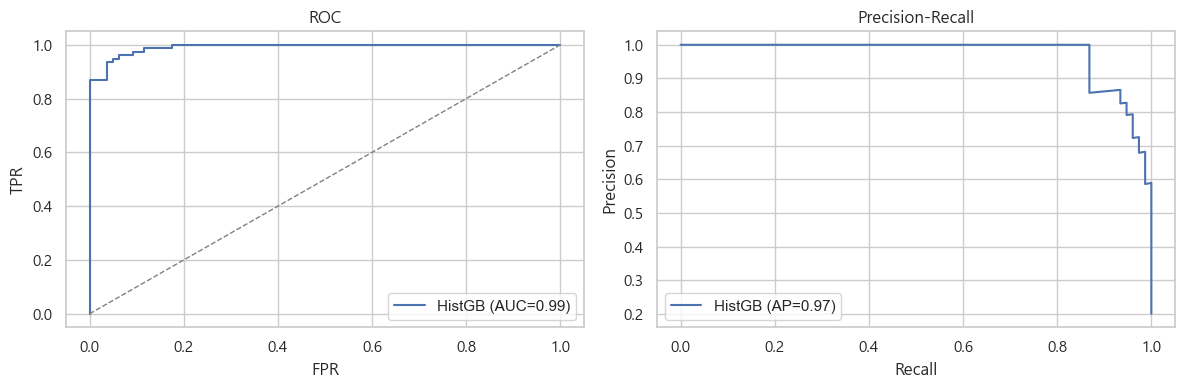


=== Top Features (Permutation AUC drop) ===


,feature,importance(AUC drop)
5,교외비중,4.859808e-01
0,평균등록금(원),1.311461e-03
3,장학금_정원당_clip,1.471607e-04
10,설립별_국공립,8.223684e-05
11,설립별_사립,4.761080e-05
2,입학정원,2.220446e-17
6,교내비중,2.220446e-17
4,장학금_등록금대비_clip,2.220446e-17
1,총계(원),1.110223e-17
7,log_평균등록금(원),0.000000e+00


저장 완료 → model_cv_auc.csv, top_features_permutation.csv


In [13]:
# =========================
#  대학 '위험군' 분류: 누수 제거 + 모델 비교 + 임계값 최적화 + 중요도
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc as sk_auc,
    classification_report, roc_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid", rc={"axes.unicode_minus": False})

# ----- 0) Helper: 한글 폰트 강제 -----
def apply_korean_to_fig(fig=None):
    import matplotlib
    try:
        matplotlib.rcParams["font.family"] = "Malgun Gothic"  # Windows
    except Exception:
        pass
    # 이모지/한글 결함 방지
    matplotlib.rcParams["axes.unicode_minus"] = False
    if fig is not None:
        for ax in fig.get_axes():
            ax.title.set_fontname("Malgun Gothic")
            ax.xaxis.label.set_fontname("Malgun Gothic")
            ax.yaxis.label.set_fontname("Malgun Gothic")
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontname("Malgun Gothic")

# ----- 1) 사용 컬럼 선정 (존재하는 것만) -----
num_cand = [
    "평균등록금(원)", "총계(원)", "입학정원",
    "장학금_정원당_clip", "장학금_등록금대비_clip",
    "교외비중", "교내비중",
    "log_평균등록금(원)", "log_총계(원)", "log_입학정원"
]
cat_cand = ["설립별", "지역별", "학제별"]

use_num = [c for c in num_cand if c in master.columns]
use_cat = [c for c in cat_cand if c in master.columns]

if "위험군" not in master.columns:
    raise RuntimeError("master 데이터에 '위험군' 열이 필요합니다.")

# 누수(라벨 정의에 직결) 변수는 반드시 제외
leak_cols = [c for c in ["불균형_Gini", "불균형_Entropy"] if c in master.columns]

feat_cols = [*use_num, *use_cat]
X_all = master[feat_cols].copy()
y_all = master["위험군"].astype(int).copy()

# ----- 2) 전처리(모델별 파이프라인) -----
from sklearn.exceptions import NotFittedError
# OneHotEncoder: 버전 호환 (dense용)
try:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older scikit-learn
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse=False)
# sparse(기본) – Logistic에서 효율 좋음
ohe_sparse = OneHotEncoder(handle_unknown="ignore")

pre_log = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler(with_mean=False))
    ]), use_num),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe_sparse)
    ]), use_cat)
], remainder="drop")

pre_hgb = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        # 트리계열은 표준화 불필요
    ]), use_num),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe_dense)
    ]), use_cat)
], remainder="drop")

models = {
    "Logistic": Pipeline([
        ("pre", pre_log),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    "HistGB": Pipeline([
        ("pre", pre_hgb),
        ("clf", HistGradientBoostingClassifier(
            learning_rate=0.05, max_depth=None,
            class_weight="balanced", random_state=42))
    ])
}

# ----- 3) OOF 예측으로 공정 비교 (Stratified 5-Fold) -----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_oof_pred(pipe, X, y):
    prob = np.zeros(len(y), dtype=float)
    for tr, te in cv.split(X, y):
        Xt, Xv = X.iloc[tr], X.iloc[te]
        yt, yv = y.iloc[tr], y.iloc[te]
        # 누수 컬럼 제거 후 학습
        Xt_ = Xt.drop(columns=[c for c in leak_cols if c in Xt.columns], errors="ignore")
        Xv_ = Xv.drop(columns=[c for c in leak_cols if c in Xv.columns], errors="ignore")
        pipe.fit(Xt_, yt)
        pr = pipe.predict_proba(Xv_)[:, 1] if hasattr(pipe, "predict_proba") else pipe.decision_function(Xv_)
        prob[te] = pr
    return prob

oof_results = {}
for name, pipe in models.items():
    oof_prob = get_oof_pred(pipe, X_all, y_all)
    auc = roc_auc_score(y_all, oof_prob)
    oof_results[name] = {"prob": oof_prob, "auc": auc}

# 요약표
summary = pd.DataFrame(
    [{"Model": k, "CV AUC": v["auc"]} for k, v in oof_results.items()]
).sort_values("CV AUC", ascending=False)
print("[CV AUC]")
display(summary)

best_name = summary.iloc[0]["Model"]
pipe_best = models[best_name]
print(f"\n[선택 모델] {best_name}")

# ----- 4) F2 기준 임계값 최적화 & 리포트 -----
def best_threshold_by_fbeta(y_true, prob, beta=2.0):
    ps, rs, th = precision_recall_curve(y_true, prob)
    f = (1+beta**2) * ps*rs / (beta**2*ps + rs + 1e-12)
    i = np.nanargmax(f)
    # precision_recall_curve가 반환하는 thresholds 길이는 ps,rs보다 1 짧음
    thr = th[i-1] if i>0 and i-1 < len(th) else 0.5
    return float(thr), float(ps[i]), float(rs[i]), float(f[i])

thr, P, R, F2 = best_threshold_by_fbeta(y_all, oof_results[best_name]["prob"], beta=2.0)
print(f"\n[확률보정 + 임계값(F2최대)] thr={thr:.3f} | Precision={P:.3f} Recall={R:.3f} F2={F2:.3f}")

y_pred_best = (oof_results[best_name]["prob"] >= thr).astype(int)
print("\n=== Classification Report @ BestThr ===")
print(classification_report(y_all, y_pred_best, digits=3, zero_division=0))

# ----- 5) ROC / PR 플롯 -----
fpr, tpr, _ = roc_curve(y_all, oof_results[best_name]["prob"])
roc_auc = roc_auc_score(y_all, oof_results[best_name]["prob"])
ps, rs, _ = precision_recall_curve(y_all, oof_results[best_name]["prob"])
ap = sk_auc(rs, ps)  # 평균정밀도

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# ROC
axes[0].plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc:.2f})")
axes[0].plot([0,1],[0,1],"--", color="gray", lw=1)
axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].set_title("ROC")
axes[0].legend(loc="lower right")
# PR
axes[1].plot(rs, ps, label=f"{best_name} (AP={ap:.2f})")
axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].set_title("Precision-Recall")
axes[1].legend(loc="lower left")
plt.tight_layout()
apply_korean_to_fig(fig)
plt.show()

# ----- 6) Permutation Importance (누수 제거 후 전체 재학습) -----
# 전체 데이터에 누수 제거 후 적합
X_noleak = X_all.drop(columns=[c for c in leak_cols if c in X_all.columns], errors="ignore")
pipe_best.fit(X_noleak, y_all)

# 전처리 이후 피처 이름 복원 (원-핫 포함)
def get_feature_names_from_pre(pre):
    """
    ColumnTransformer/파이프라인에서 최종 변환된 컬럼명을 안전하게 추출
    (OneHotEncoder, Passthrough, Imputer/Scaler 조합 대응)
    """
    try:
        names = pre.get_feature_names_out()
        return np.array([n.split("__", 1)[-1] for n in names], dtype=object)
    except Exception:
        names = []
        for name, trans, cols in pre.transformers_:
            if name == "remainder":
                if trans == "passthrough":
                    out = np.array(cols, dtype=object)
                else:
                    continue
            else:
                if hasattr(trans, "steps"):
                    last = trans.steps[-1][1]
                    if hasattr(last, "get_feature_names_out"):
                        out = last.get_feature_names_out(cols)
                    else:
                        out = np.array(cols, dtype=object)
                else:
                    if hasattr(trans, "get_feature_names_out"):
                        out = trans.get_feature_names_out(cols)
                    else:
                        out = np.array(cols, dtype=object)
            if isinstance(out, (list, tuple)):
                out = np.array(out, dtype=object)
            names.extend(out.tolist())
        names = [str(n).split("__", 1)[-1] for n in names]
        return np.array(names, dtype=object)

feat_names = get_feature_names_from_pre(pipe_best.named_steps["pre"])

r = permutation_importance(
    pipe_best, X_noleak, y_all,
    scoring="roc_auc", n_repeats=10,
    random_state=42, n_jobs=-1
)
n = min(len(feat_names), r.importances_mean.shape[0])
imp_df = (pd.DataFrame({
            "feature": feat_names[:n],
            "importance(AUC drop)": r.importances_mean[:n]
         })
         .sort_values("importance(AUC drop)", ascending=False)
         .head(20))
print("\n=== Top Features (Permutation AUC drop) ===")
display(imp_df)

# ----- (선택) 모델/결과 저장 -----
summary.to_csv("model_cv_auc.csv", index=False, encoding="utf-8-sig")
imp_df.to_csv("top_features_permutation.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → model_cv_auc.csv, top_features_permutation.csv")

## 11. 홀드아웃 + 확률 보정(캘리브레이션) + 임계값 테이블

[AUC] train=1.000 | test=0.990
[AP ] train=1.000 | test=0.967
[Brier] test=0.0366


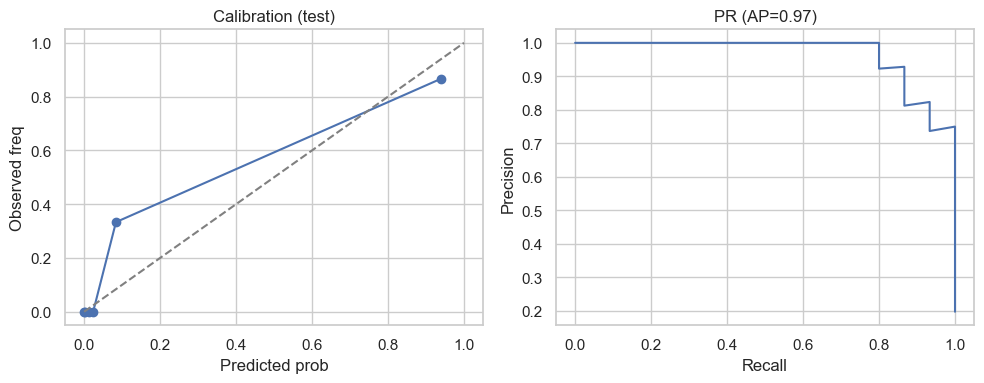

,thr,precision,recall,F2,alerts
1,0.031,0.714286,1.000000,0.925926,21
2,0.051,0.714286,1.000000,0.925926,21
3,0.072,0.823529,0.933333,0.909091,17
4,0.093,0.823529,0.933333,0.909091,17
9,0.196,0.866667,0.866667,0.866667,15
8,0.176,0.866667,0.866667,0.866667,15
7,0.155,0.866667,0.866667,0.866667,15
11,0.238,0.866667,0.866667,0.866667,15
12,0.259,0.866667,0.866667,0.866667,15
13,0.279,0.866667,0.866667,0.866667,15


[Best thr by F2] thr=0.031
              precision    recall  f1-score   support

           0      1.000     0.902     0.948        61
           1      0.714     1.000     0.833        15

    accuracy                          0.921        76
   macro avg      0.857     0.951     0.891        76
weighted avg      0.944     0.921     0.926        76



In [14]:
# === Hold-out + Calibration + Threshold table ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             precision_recall_curve, classification_report)

sns.set(style="whitegrid")

# 0) 피처 셋 정의 (있는 것만 사용)
num_cand = ["평균등록금(원)","입학정원","총계(원)","장학금_정원당_clip",
            "장학금_등록금대비_clip","교외비중","교내비중",
            "log_평균등록금(원)","log_총계(원)","log_입학정원"]
cat_cand = ["설립별"]
use_num = [c for c in num_cand if c in master.columns]
use_cat = [c for c in cat_cand if c in master.columns]
feat = use_num + use_cat

df = master.dropna(subset=["위험군"] + use_num).copy()
X = df[feat].copy()
y = df["위험군"].astype(int).values

pre = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler())]), use_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), use_cat)
])

base = HistGradientBoostingClassifier(
    learning_rate=0.08, max_depth=None, max_iter=400,
    l2_regularization=0.0, class_weight="balanced", random_state=42
)
pipe = Pipeline([("pre", pre), ("clf", base)])

# 1) hold-out
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(sss.split(X, y))
Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
ytr, yte = y[tr_idx], y[te_idx]

# 2) 캘리브레이션 (isotonic)
cal = CalibratedClassifierCV(estimator=pipe, method="isotonic", cv=5)
cal.fit(Xtr, ytr)

pro_tr = cal.predict_proba(Xtr)[:,1]
pro_te = cal.predict_proba(Xte)[:,1]

print(f"[AUC] train={roc_auc_score(ytr, pro_tr):.3f} | test={roc_auc_score(yte, pro_te):.3f}")
print(f"[AP ] train={average_precision_score(ytr, pro_tr):.3f} | test={average_precision_score(yte, pro_te):.3f}")
print(f"[Brier] test={brier_score_loss(yte, pro_te):.4f}")

# 3) 캘리브레이션 곡선
fig, ax = plt.subplots(1,2, figsize=(10,4))
prob_true, prob_pred = calibration_curve(yte, pro_te, n_bins=10, strategy="quantile")
ax[0].plot(prob_pred, prob_true, marker="o"); ax[0].plot([0,1],[0,1],"--",c="gray")
ax[0].set_title("Calibration (test)"); ax[0].set_xlabel("Predicted prob"); ax[0].set_ylabel("Observed freq")
# PR
ps, rs, _ = precision_recall_curve(yte, pro_te); ap = average_precision_score(yte, pro_te)
ax[1].plot(rs, ps); ax[1].set_title(f"PR (AP={ap:.2f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
plt.tight_layout(); plt.show()

# 4) 임계값 그리드 테이블
def metrics_at_thr(y_true, prob, thr):
    pred = (prob >= thr).astype(int)
    tp = ((pred==1)&(y_true==1)).sum()
    fp = ((pred==1)&(y_true==0)).sum()
    fn = ((pred==0)&(y_true==1)).sum()
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    f2 = (5*prec*rec)/(4*prec+rec+1e-9)
    return prec, rec, f2, tp+fp

grid = np.round(np.linspace(0.01, 0.30, 15), 3)
rows=[]
for t in grid:
    p,r,f2,alerts = metrics_at_thr(yte, pro_te, t)
    rows.append([t,p,r,f2,alerts])
thr_table = pd.DataFrame(rows, columns=["thr","precision","recall","F2","alerts"]).sort_values("F2", ascending=False)
display(thr_table.head(10))

# 5) 베스트 F2 임계값 보고서
best_idx = thr_table["F2"].idxmax()
tbest = thr_table.loc[best_idx,"thr"]
print(f"[Best thr by F2] thr={tbest:.3f}")
print(classification_report(yte, (pro_te>=tbest).astype(int), digits=3))

## 12. 부분의존(효과곡선) – 상위 수치 피처 3개

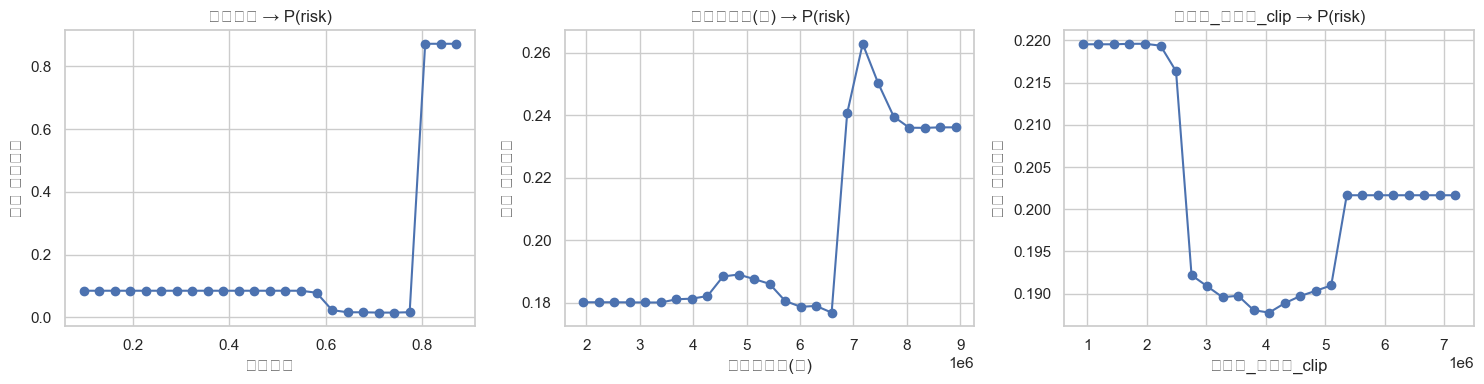

In [15]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

def pd_curve(pipe_or_cal, Xref, col, q=(1,99), n=25):
    lo, hi = np.percentile(Xref[col].dropna(), q)
    grid = np.linspace(lo, hi, n)
    Xtmp = Xref.copy()
    ys=[]
    for v in grid:
        Xtmp[col] = v
        ys.append(pipe_or_cal.predict_proba(Xtmp)[:,1].mean())
    return grid, np.array(ys)

top_numeric = [c for c in ["교외비중","평균등록금(원)","장학금_정원당_clip"] if c in X.columns][:3]

fig, axes = plt.subplots(1, len(top_numeric), figsize=(5*len(top_numeric),4))
if len(top_numeric)==1: axes=[axes]
for ax, col in zip(axes, top_numeric):
    gx, gy = pd_curve(cal, Xte, col)
    ax.plot(gx, gy, marker="o"); ax.set_title(f"{col} → P(risk)")
    ax.set_xlabel(col); ax.set_ylabel("평균 위험확률")
plt.tight_layout(); plt.show()

## 

## 13. 그룹별 성능 (설립/지역) – 공정성·집단 편향 점검

In [16]:
import pandas as pd, numpy as np

def group_report(df, group_col, prob, thr):
    out=[]
    for g, sub in df.groupby(group_col):
        y_true = sub["위험군"].astype(int).values
        y_pred = (prob[sub.index] >= thr).astype(int)
        tp = ((y_pred==1)&(y_true==1)).sum()
        fp = ((y_pred==1)&(y_true==0)).sum()
        fn = ((y_pred==0)&(y_true==1)).sum()
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        out.append([g, len(sub), prec, rec])
    return pd.DataFrame(out, columns=[group_col,"n","precision","recall"]).sort_values("recall", ascending=False)

t_use = float(thr_table.loc[best_idx,"thr"])
df_te = df.iloc[te_idx].copy()
df_te["prob"] = pro_te

print("[설립별]")
display(group_report(df_te, "설립별", df_te["prob"], t_use))
if "지역별" in df_te.columns:
    print("[지역별]")
    display(group_report(df_te, "지역별", df_te["prob"], t_use).head(15))


[설립별]


,설립별,n,precision,recall
1,사립,64,0.705882,1.0
0,국공립,12,0.750000,1.0


[지역별]


,지역별,n,precision,recall
2,경남,6,1.000000,1.0
6,부산,8,1.000000,1.0
7,서울,16,0.500000,1.0
10,전남,6,0.666667,1.0
3,경북,5,0.500000,1.0
1,경기,9,0.500000,1.0
0,강원,2,1.000000,1.0
5,대구,5,1.000000,1.0
4,광주,4,1.000000,1.0
14,충북,5,1.000000,1.0


## 14. 최종 스코어링 파일 내보내기 (리스크 리스트)

In [17]:
score = df.copy()
score["prob"] = cal.predict_proba(X)[:,1]
score["pred@bestF2"] = (score["prob"] >= tbest).astype(int)
cols_show = ["대학키","설립별","지역별","평균등록금(원)","입학정원","총계(원)","교외비중","교내비중",
             "장학금_정원당_clip","장학금_등록금대비_clip","prob","pred@bestF2"]
cols_show = [c for c in cols_show if c in score.columns]
score_out = score[cols_show].sort_values("prob", ascending=False)
score_out.to_csv("risk_scored_list.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → risk_scored_list.csv")
display(score_out.head(20))

저장 완료 → risk_scored_list.csv


,대학키,설립별,지역별,평균등록금(원),입학정원,총계(원),교외비중,교내비중,장학금_정원당_clip,장학금_등록금대비_clip,prob,pred@bestF2
379,화신사이버대학,사립,부산,2527107.2,1586,4645232547,0.874364,0.125636,2.928898e+06,1838.162048,1.0,1
347,한국폴리텍 VII 대학 울산캠퍼스,사립,울산,2432000.0,535,939556002,0.821137,0.178863,1.756179e+06,386.330593,1.0,1
348,한국폴리텍 VII 대학 창원캠퍼스,사립,경남,2432000.0,1125,2206152001,0.857431,0.142569,1.961024e+06,907.134869,1.0,1
350,한국폴리텍 특성화대학 바이오캠퍼스,사립,충남,2595000.0,320,542456250,0.820774,0.179226,1.695176e+06,209.039017,1.0,1
349,한국폴리텍 특성화대학 로봇캠퍼스,사립,경북,2164000.0,200,189154667,0.826872,0.173128,9.457733e+05,87.409735,1.0,1
352,한국폴리텍 특성화대학 항공캠퍼스,사립,경남,2308426.5,340,442862112,0.821183,0.178817,1.302536e+06,191.845879,1.0,1
354,한국해양대학,국공립,부산,3721746.4,5488,16989239437,0.816345,0.183655,3.095707e+06,4564.856820,1.0,1
346,한국폴리텍 VII 대학 부산캠퍼스,사립,부산,2432000.0,650,1116400502,0.831665,0.168335,1.717539e+06,459.046259,1.0,1
342,한국폴리텍 VI 대학 대구캠퍼스,사립,대구,2432000.0,535,801099000,0.844256,0.155744,1.497381e+06,329.399260,1.0,1
341,한국폴리텍 VI 대학 구미캠퍼스,사립,경북,2432000.0,470,735233000,0.831324,0.168676,1.564326e+06,302.316201,1.0,1


## 15. “최소 개입으로 안전선 아래로” 개인화 액션 산출

In [18]:
# === 최소 개입 산출: 교외비중/정원당 장학금으로 thr 아래로 ===
import numpy as np
import pandas as pd

thr  = 0.031   # 셀 A에서 고른 임계값
topN = 50      # 상위 위험 N개만 액션 계산

# 0) 파이프라인에서 학습 입력 컬럼 복구
pre = None
for n in ["pre", "prep", "preprocess", "preprocessor"]:
    if n in pipe_best.named_steps:
        pre = pipe_best.named_steps[n]
        break
if pre is None:
    raise RuntimeError("전처리 스텝을 찾지 못했습니다(pre/prep/...). 파이프라인 스텝 이름을 확인하세요.")

feat_in = list(getattr(pre, "feature_names_in_", []))
if not feat_in:
    try:
        feat_in = list(num_cols) + list(cat_cols)  # 노트북에 있는 변수로 백업
    except Exception:
        raise RuntimeError("학습 입력 컬럼(feature_names_in_)을 복구할 수 없습니다.")

# 1) 모델 입력 구성
Xcols = feat_in
X_pred = master[Xcols].copy()

def min_change_to_safe(row, feat, lo, hi, step):
    """
    단일 피처(feat)를 lo→hi로 움직이며 prob<thr가 되는 가장 작은 변화 찾기.
    step은 부호 포함(증가/감소).
    """
    base = row.copy()
    orig = base[feat]
    if (hi - lo) * step < 0:
        step = -step
    grid = np.arange(lo, hi + step/1000.0, step)

    best_val, best_prob = None, 1.0
    for v in grid:
        base[feat] = v
        prob = pipe_best.predict_proba(pd.DataFrame([base[Xcols]]))[0, 1]
        if prob < thr:
            best_val, best_prob = v, prob
            break

    base[feat] = orig
    if best_val is None:
        return np.nan, np.nan, np.nan
    return best_val, best_val - orig, best_prob

# 2) 현재 확률을 구해 TopN 위험대학 선택
scored = master.copy()
scored["prob"] = pipe_best.predict_proba(X_pred)[:, 1]
risk_top = (scored.sort_values("prob", ascending=False)
                   .head(topN)
                   .reset_index(drop=True))

# 3) 두 레버(교외비중, 장학금_정원당_clip)로 최소 개입 계산
rows = []
has_out = "교외비중" in Xcols
has_per = "장학금_정원당_clip" in Xcols
if has_per:
    lo_q = float(master["장학금_정원당_clip"].quantile(0.05))
    hi_q = float(master["장학금_정원당_clip"].quantile(0.95))

for _, r in risk_top.iterrows():
    base_prob = r["prob"]

    # 교외비중 ↓ (현재값 → 0)
    if has_out:
        v1, d1, p1 = min_change_to_safe(r, "교외비중", lo=r["교외비중"], hi=0.0, step=-0.002)
    else:
        v1 = d1 = p1 = np.nan

    # 정원당 장학금(양/음 양쪽 시도 후 |delta|가 작은 쪽 선택)
    if has_per:
        v2a, d2a, p2a = min_change_to_safe(r, "장학금_정원당_clip",
                                           lo=r["장학금_정원당_clip"], hi=lo_q, step=-1e5)
        v2b, d2b, p2b = min_change_to_safe(r, "장학금_정원당_clip",
                                           lo=r["장학금_정원당_clip"], hi=hi_q, step= 1e5)
        cands = [(v2a, d2a, p2a), (v2b, d2b, p2b)]
        cands = [c for c in cands if not (pd.isna(c[0]) or pd.isna(c[1]) or pd.isna(c[2]))]
        if cands:
            v2, d2, p2 = sorted(cands, key=lambda x: abs(x[1]))[0]
        else:
            v2 = d2 = p2 = np.nan
    else:
        v2 = d2 = p2 = np.nan

    rows.append({
        "대학키": r.get("대학키", np.nan),
        "학교명": r.get("학교명", r.get("대학명", "")),
        "현재_prob": round(base_prob, 4),
        "교외비중_new": v1, "교외비중_delta": d1, "prob_after_교외비중": p1,
        "정원당_new": v2,   "정원당_delta": d2,   "prob_after_정원당": p2
    })

action = pd.DataFrame(rows)

# 4) 거친 비용 추정(교외비중 Δ만큼 내리면 총계×Δ 만큼 교내 재원 필요)
if {"총계(원)", "교외비중"}.issubset(master.columns):
    action = action.merge(master[["대학키", "총계(원)"]], on="대학키", how="left")
    action["추가_교내장학금(원)_대략"] = (action["교외비중_delta"].abs() * action["총계(원)"]).round()

display(action.head(10))
action.to_csv("risk_action_plan_counterfactual.csv", index=False, encoding="utf-8-sig")
print("저장 완료 → risk_action_plan_counterfactual.csv")

,대학키,학교명,현재_prob,교외비중_new,교외비중_delta,prob_after_교외비중,정원당_new,정원당_delta,prob_after_정원당,총계(원),추가_교내장학금(원)_대략
0,성운대학,,0.9967,0.802174,-0.014,0.003593,NaN,NaN,NaN,6813699750,95391797.0
1,순천제일대학,,0.9967,0.802653,-0.014,0.003665,NaN,NaN,NaN,9436554548,132111764.0
2,건양사이버대학,,0.9967,0.802486,-0.042,0.006382,NaN,NaN,NaN,8470140245,355745890.0
3,대구사이버대학,,0.9967,0.801854,-0.022,0.004564,NaN,NaN,NaN,6532602602,143717257.0
4,동강대학,,0.9967,0.801553,-0.036,0.003663,NaN,NaN,NaN,9228912405,332240847.0
5,제주관광대학,,0.9967,0.802077,-0.070,0.004620,NaN,NaN,NaN,5541407462,387898522.0
6,동아보건대학,,0.9967,0.803098,-0.058,0.005010,NaN,NaN,NaN,4142284225,240252485.0
7,한국폴리텍 II 대학 인천캠퍼스,,0.9967,0.802383,-0.030,0.004974,NaN,NaN,NaN,2212756650,66382700.0
8,부산디지털대학,,0.9967,0.802705,-0.066,0.005347,NaN,NaN,NaN,4975486650,328382119.0
9,영진사이버대학,,0.9967,0.801506,-0.070,0.006911,NaN,NaN,NaN,7671802100,537026147.0


저장 완료 → risk_action_plan_counterfactual.csv


## 16. 빠른 요약·집계(얼마나 들어가고, 몇 곳을 살릴 수 있나?)

In [19]:
# action 은 방금 만든 DataFrame
summ = action.copy()
summ["pp_delta"] = summ["교외비중_delta"] * 100  # 퍼센트포인트

print("대상 수:", len(summ))
print("교외비중 변화 범위(pp):", f"{summ['pp_delta'].min():.1f} ~ {summ['pp_delta'].max():.1f}")
print("추가 교내 재원(원) 합계:", f"{summ['추가_교내장학금(원)_대략'].sum():,.0f}")
print("추가 교내 재원(원) 중앙값:", f"{summ['추가_교내장학금(원)_대략'].median():,.0f}")

# 비용-효율 상위 목록(가장 적은 돈으로 안전권)
display(summ.sort_values("추가_교내장학금(원)_대략").head(15))

대상 수: 50
교외비중 변화 범위(pp): -19.8 ~ -0.2
추가 교내 재원(원) 합계: 7,028,558,942
추가 교내 재원(원) 중앙값: 38,932,504


,대학키,학교명,현재_prob,교외비중_new,교외비중_delta,prob_after_교외비중,정원당_new,정원당_delta,prob_after_정원당,총계(원),추가_교내장학금(원)_대략,pp_delta
14,한국폴리텍 II 대학 남인천캠퍼스,,0.9967,0.801407,-0.004,0.003342,NaN,NaN,NaN,73091000,292364.0,-0.4
12,한국폴리텍 V 대학 전남캠퍼스,,0.9967,0.802597,-0.014,0.003342,NaN,NaN,NaN,214380334,3001325.0,-1.4
28,한국폴리텍 특성화대학 로봇캠퍼스,,0.9967,0.802872,-0.024,0.003342,NaN,NaN,NaN,189154667,4539712.0,-2.4
31,한국폴리텍 VI 대학 영주캠퍼스,,0.9967,0.802532,-0.076,0.003342,NaN,NaN,NaN,67178000,5105528.0,-7.6
17,부산예술대학,,0.9967,0.803232,-0.002,0.003184,NaN,NaN,NaN,2937327912,5874656.0,-0.2
16,순복음총회신학교,,0.9967,0.801474,-0.014,0.004864,NaN,NaN,NaN,518680000,7261520.0,-1.4
29,한국폴리텍 특성화대학 항공캠퍼스,,0.9967,0.803183,-0.018,0.003342,NaN,NaN,NaN,442862112,7971518.0,-1.8
19,한국폴리텍 III 대학 강릉캠퍼스,,0.9967,0.802378,-0.042,0.003342,NaN,NaN,NaN,197514680,8295617.0,-4.2
26,한국폴리텍 V 대학 익산캠퍼스,,0.9967,0.801900,-0.050,0.003342,NaN,NaN,NaN,168076000,8403800.0,-5.0
21,대전신학대학,,0.9967,0.803307,-0.032,0.004864,NaN,NaN,NaN,266496760,8527896.0,-3.2


## 17. 예산 B에서 최대 몇 곳을 살릴 수 있나? (탐욕적 계획)

In [20]:
B = 2_000_000_000  # 예: 20억
plan = action.sort_values("추가_교내장학금(원)_대략").reset_index(drop=True)
plan["누적비용"] = plan["추가_교내장학금(원)_대략"].cumsum()
k = int((plan["누적비용"] <= B).sum())

print(f"예산 {B:,.0f}원으로 구제 가능한 대학 수:", k)
display(plan.loc[:max(k-1,0), ["학교명","현재_prob","교외비중_delta","추가_교내장학금(원)_대략","누적비용"]])

예산 2,000,000,000원으로 구제 가능한 대학 수: 37


,학교명,현재_prob,교외비중_delta,추가_교내장학금(원)_대략,누적비용
0,,0.9967,-0.004,292364.0,2.923640e+05
1,,0.9967,-0.014,3001325.0,3.293689e+06
2,,0.9967,-0.024,4539712.0,7.833401e+06
3,,0.9967,-0.076,5105528.0,1.293893e+07
4,,0.9967,-0.002,5874656.0,1.881358e+07
5,,0.9967,-0.014,7261520.0,2.607510e+07
6,,0.9967,-0.018,7971518.0,3.404662e+07
7,,0.9967,-0.042,8295617.0,4.234224e+07
8,,0.9967,-0.050,8403800.0,5.074604e+07
9,,0.9967,-0.032,8527896.0,5.927394e+07


## 18. 예산-성과 프런티어(효율 곡선) 그리기

,예산(원),구제_대학수,투입비용(원)
0,2.000000e+09,37,1.768710e+09
1,5.000000e+09,46,4.636199e+09
2,1.000000e+10,50,7.028559e+09
3,2.000000e+10,50,7.028559e+09
4,3.000000e+10,50,7.028559e+09
5,5.000000e+10,50,7.028559e+09


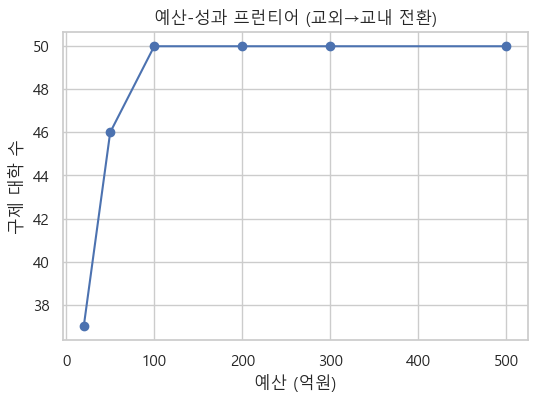

In [21]:
import numpy as np
import matplotlib.pyplot as plt

budgets = [2e9, 5e9, 10e9, 20e9, 30e9, 50e9]  # 예산 리스트
plan = action.sort_values("추가_교내장학금(원)_대략").reset_index(drop=True)
plan["누적비용"] = plan["추가_교내장학금(원)_대략"].cumsum()

front = []
for B in budgets:
    k = int((plan["누적비용"] <= B).sum())
    front.append((B, k, plan.loc[:max(k-1,0), "추가_교내장학금(원)_대략"].sum()))

front_df = pd.DataFrame(front, columns=["예산(원)","구제_대학수","투입비용(원)"])
display(front_df)

apply_korean_to_fig(fig)   # ← fig를 명시적으로 전달
plt.figure(figsize=(6,4))
plt.plot(front_df["예산(원)"]/1e8, front_df["구제_대학수"], marker="o")
plt.xlabel("예산 (억원)")
plt.ylabel("구제 대학 수")
plt.title("예산-성과 프런티어 (교외→교내 전환)")
plt.grid(True); plt.show()

## 19. SHAP 전역/개별 설명으로 해석 강화

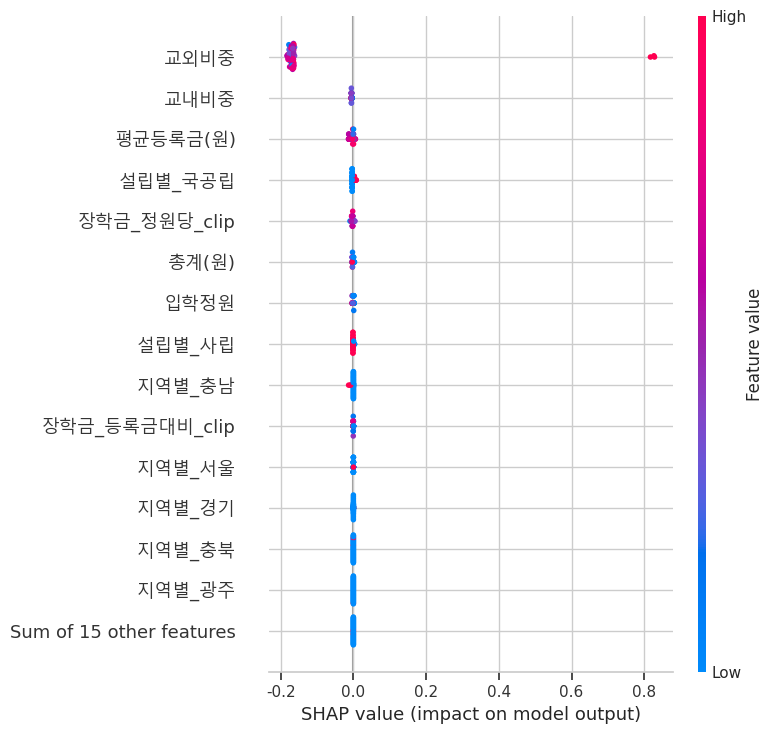

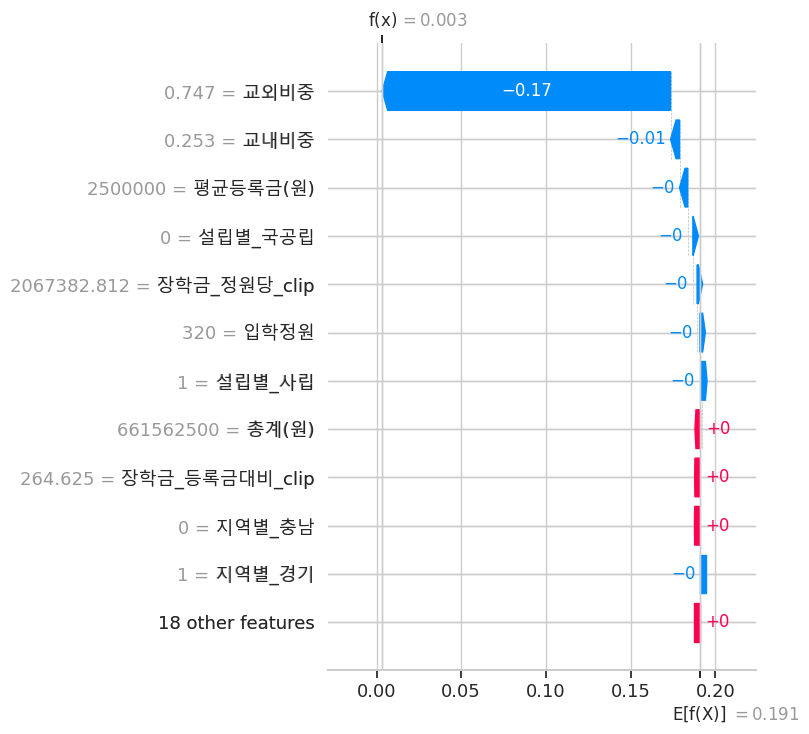

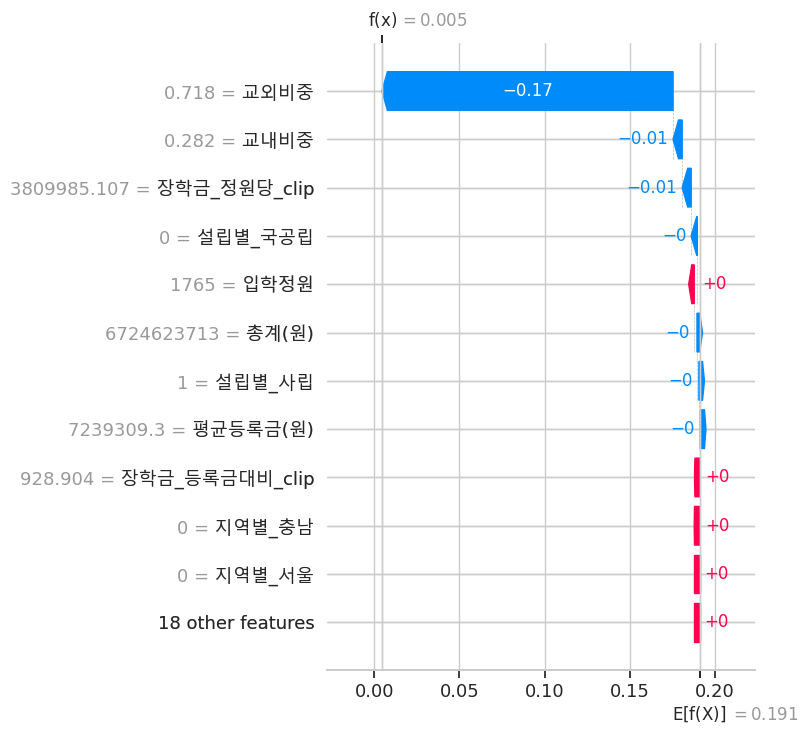

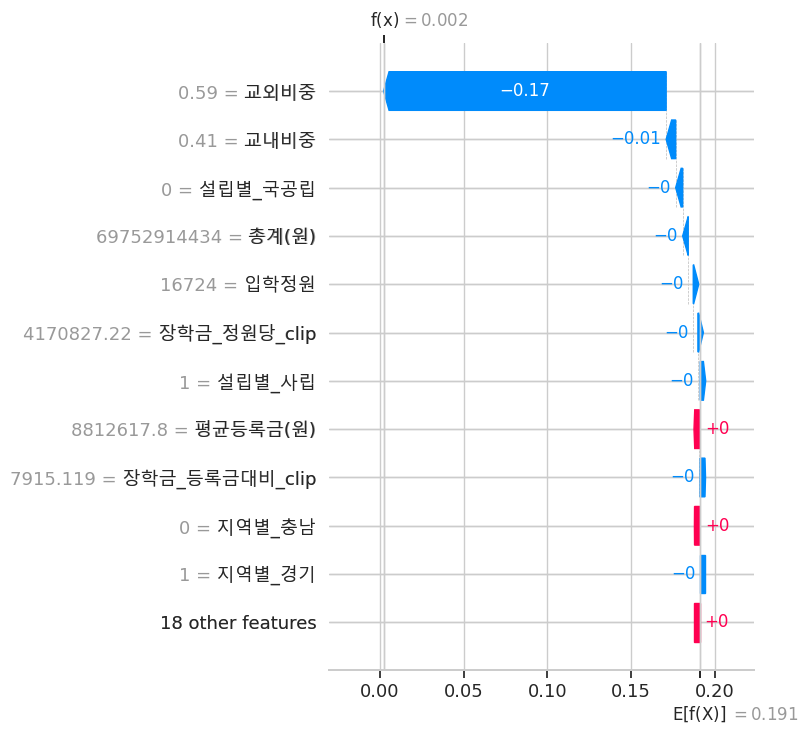

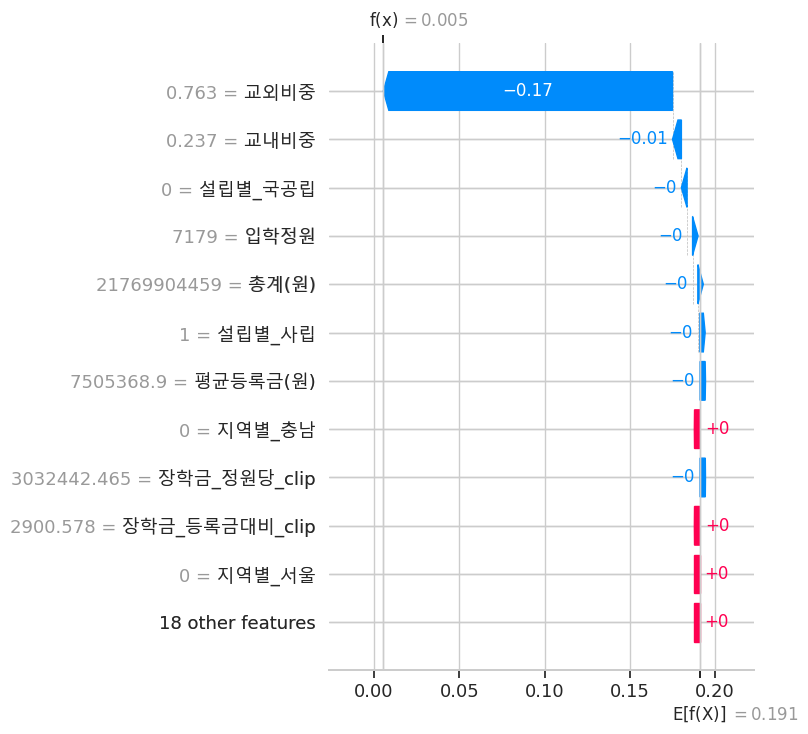

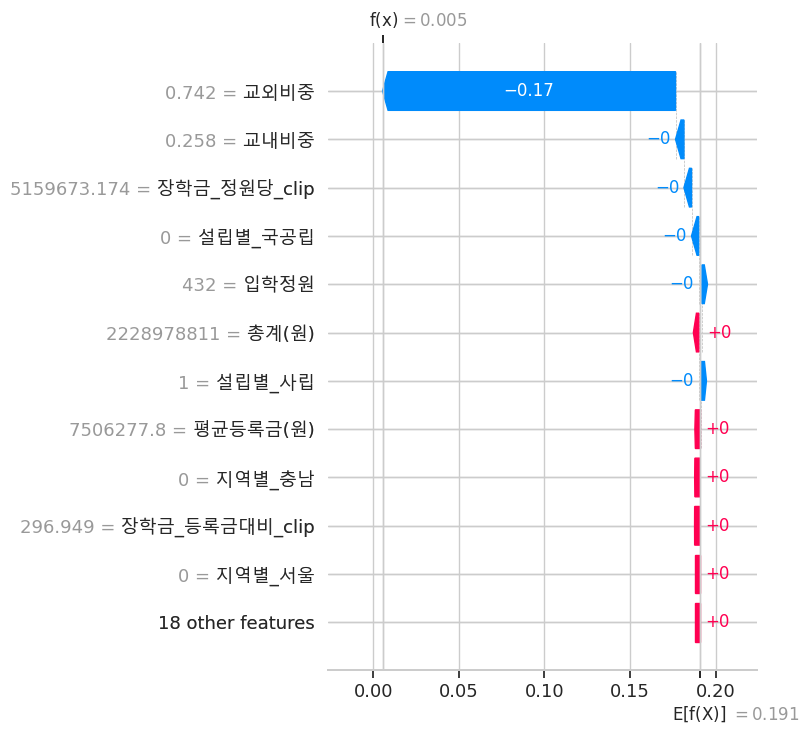

In [22]:
# === SHAP on preprocessed features (with font fallback to avoid '□') ===
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import scipy.sparse as sp
from matplotlib import rcParams

# [폰트 네모 방지] DejaVu Sans(기호/수식/마이너스) + Malgun Gothic(한글) 동시 사용
rcParams.update({
    "font.family": ["DejaVu Sans", "Malgun Gothic"],  # 순서: 먼저 DejaVu Sans, 그다음 말굽
    "axes.unicode_minus": False,                      # U+2212 대신 ASCII '-'
})

pre = pipe_best.named_steps["pre"]
clf = pipe_best.named_steps["clf"]

# 0) 파이프라인이 기대하는 입력 컬럼 수집
def expected_input_columns(pre):
    cols = []
    for name, trans, sel in pre.transformers_:
        if sel is None or sel == "drop":
            continue
        if isinstance(sel, (list, tuple, np.ndarray, pd.Index)):
            cols += list(sel)
        else:
            cols += list(sel)
    return list(dict.fromkeys(cols))

exp_cols = expected_input_columns(pre)

# master에서 기대 컬럼 정합 맞추기(없으면 NaN 생성) + 순서 통일
X_full = master.copy()
for c in exp_cols:
    if c not in X_full.columns:
        X_full[c] = np.nan
X_full = X_full[exp_cols]

# 희소→밀집 도우미
def to_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

# 전처리 후 피처명(수치 + OHE) 복원
def feature_names_after_pre(pre):
    num_names, cat_cols = [], []
    for name, trans, sel in pre.transformers_:
        if name == "num":
            num_names = list(sel)
        if name == "cat":
            cat_cols = list(sel)
    cat_names = []
    if "cat" in pre.named_transformers_:
        ohe = pre.named_transformers_["cat"].named_steps.get("ohe", None) \
              if hasattr(pre.named_transformers_["cat"], "named_steps") else pre.named_transformers_["cat"]
        if ohe is not None and hasattr(ohe, "get_feature_names_out"):
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
        else:
            cat_names = cat_cols
    return num_names + cat_names

feat_names = feature_names_after_pre(pre)

# 1) 배경(참조) 데이터: 샘플 → 전처리 → 밀집
X_bg_raw = shap.sample(X_full, 300, random_state=42)
X_bg = to_dense(pre.transform(X_bg_raw))

# 2) SHAP이 호출할 함수: "전처리 끝난 행렬" -> 확률(두 클래스 반환)
def fZ(Z):
    return clf.predict_proba(Z)

# 3) Explainer 구성
masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(
    fZ, masker=masker,
    algorithm="permutation",
    feature_names=feat_names
)

# 4) 설명할 표본 선택 (risk_top 있으면 그 인덱스 사용, 없으면 샘플)
if "risk_top" in globals():
    idx = risk_top.index
    to_explain_raw = X_full.loc[idx]
else:
    to_explain_raw = shap.sample(X_full, 120, random_state=0)

Z = to_dense(pre.transform(to_explain_raw))

# 5) SHAP 값 계산
sv = explainer(Z, silent=True)

# 6) 이진분류 class=1 축 선택(버전 호환)
try:
    sv1 = sv[..., 1]
except Exception:
    sv1 = sv[:, :, 1]

# 7) 전역 요약(중요도/방향)
shap.plots.beeswarm(sv1, max_display=15, show=False)
plt.tight_layout(); plt.show()

# 8) 개별 waterfall (상위 5개)
n_show = min(5, sv1.values.shape[0])
for i in range(n_show):
    # 타이틀에 학교명/확률 넣기(있으면)
    title = None
    if "학교명" in master.columns:
        title = f"{master.loc[to_explain_raw.index[i], '학교명']} (prob={pipe_best.predict_proba(to_dense(pre.transform(X_full.loc[[to_explain_raw.index[i]]])))[0,1]:.3f})"
    elif "대학명" in master.columns:
        title = f"{master.loc[to_explain_raw.index[i], '대학명']} (prob={pipe_best.predict_proba(to_dense(pre.transform(X_full.loc[[to_explain_raw.index[i]]])))[0,1]:.3f})"

    shap.plots.waterfall(sv1[i], max_display=12, show=False)
    if title: plt.title(title)
    plt.tight_layout(); plt.show()


## 20. 운영 전 최종 점검 & 배포 패키징

In [23]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

## 20-1. 확률 보정(캘리브레이션) + 임계값(F2) 재탐색 & 저장

In [25]:
# 6-1 (PATCH): 캘리브레이션 + F2 임계값 재탐색 (파이프라인 기대 컬럼으로 정합)

import numpy as np, pandas as pd, os, joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import fbeta_score
from sklearn.base import clone

# --- 0) 파이프라인이 기대하는 입력 열을 추출 → master에서 정합 DF 만들기
pre = pipe_best.named_steps["pre"]

def expected_input_columns(pre):
    cols = []
    for name, trans, sel in pre.transformers_:
        if sel is None or sel == "drop":
            continue
        if isinstance(sel, (list, tuple, np.ndarray, pd.Index)):
            cols += list(sel)
        else:
            cols += list(sel)
    # 중복 제거 + 순서 보존
    return list(dict.fromkeys(cols))

exp_cols = expected_input_columns(pre)

X_in = master.copy()
for c in exp_cols:
    if c not in X_in.columns:
        X_in[c] = np.nan
X_in = X_in[exp_cols]   # 순서 맞추기

# 타깃 정합
if "y" in globals() and len(y) == len(X_in):
    y_in = pd.Series(y, index=X_in.index).astype(int)
else:
    y_in = master["위험군"].astype(int)

print(f"[INFO] X_in shape={X_in.shape}, y_in={y_in.shape}. 사용 컬럼수={len(exp_cols)}")

# --- 1) Isotonic 캘리브레이션(전 데이터 기준)
cal = CalibratedClassifierCV(pipe_best, method="isotonic", cv=5)
cal.fit(X_in, y_in)
print("[OK] calibrated model fitted.")

# --- 2) 교차검증 아웃-오브-폴드 확률로 F2 최적 임계값 찾기(보정 확률 기준)
def best_thr_f2_calibrated(pipe, X, y, grid=None, n_splits=5, random_state=42):
    if grid is None:
        grid = np.linspace(0.005, 0.20, 80)  # 낮은 확률 영역부터 조밀하게 탐색
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_prob = np.zeros(len(X), dtype=float)
    for tr, te in skf.split(X, y):
        # 각 폴드에서 파이프라인 새로 복제 → 보정까지 포함
        base = clone(pipe)
        cal_fold = CalibratedClassifierCV(base, method="isotonic", cv=5)
        cal_fold.fit(X.iloc[tr], y.iloc[tr])
        oof_prob[te] = cal_fold.predict_proba(X.iloc[te])[:, 1]

    # F2 최적 임계값
    def f2_at_thr(thr):
        pred = (oof_prob >= thr).astype(int)
        return fbeta_score(y, pred, beta=2, zero_division=0)

    scores = [(t, f2_at_thr(t)) for t in grid]
    t_best, s_best = max(scores, key=lambda x: x[1])
    return t_best, s_best, oof_prob

thr_cal, f2_cal, oof_prob = best_thr_f2_calibrated(pipe_best, X_in, y_in)
print(f"[Calibration] Best F2 thr = {thr_cal:.3f} | CV-F2={f2_cal:.3f}")

# --- 3) 아티팩트 저장
os.makedirs("artifacts", exist_ok=True)
joblib.dump(
    {"raw": pipe_best, "calibrated": cal, "best_thr_cal": float(thr_cal),
     "exp_cols": exp_cols},
    "artifacts/risk_model_pack.joblib"
)
print("saved → artifacts/risk_model_pack.joblib")

[INFO] X_in shape=(380, 12), y_in=(380,). 사용 컬럼수=12
[OK] calibrated model fitted.
[Calibration] Best F2 thr = 0.170 | CV-F2=0.902
saved → artifacts/risk_model_pack.joblib


## 20-2. 안정성 스트레스 테스트(시드/폴드 바꿔 재현성 확인)

In [27]:
# (PATCH) 안정성 스트레스 테스트: X_in / y_in 사용 + fold별 캘리브레이션
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# 20-1에서 만든 입력/타깃을 확정 (인덱스 정렬)
Xi = X_in.reset_index(drop=True)
yi = y_in.reset_index(drop=True)

def stress_once(seed=0, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    aucs, aps = [], []
    for tr, te in skf.split(Xi, yi):
        # 각 폴드에서 새 파이프라인을 만들고 isotonic 보정까지 포함해 학습
        base = clone(pipe_best)  # unfitted pipeline
        cal_fold = CalibratedClassifierCV(base, method="isotonic", cv=5)
        cal_fold.fit(Xi.iloc[tr], yi.iloc[tr])

        p = cal_fold.predict_proba(Xi.iloc[te])[:, 1]
        aucs.append(roc_auc_score(yi.iloc[te], p))
        aps.append(average_precision_score(yi.iloc[te], p))
    return np.mean(aucs), np.std(aucs), np.mean(aps), np.std(aps)

stab = pd.DataFrame(
    [stress_once(s) for s in range(10)],
    columns=["AUC_mean","AUC_std","AP_mean","AP_std"]
)
display(stab.describe().T)

import os
os.makedirs("artifacts", exist_ok=True)
stab.to_csv("artifacts/stability_summary.csv", index=False, encoding="utf-8-sig")
print("saved → artifacts/stability_summary.csv")

,count,mean,std,min,25%,50%,75%,max
AUC_mean,10.0,0.988724,0.001846,0.985552,0.988449,0.988925,0.989933,0.991028
AUC_std,10.0,0.014827,0.001994,0.011078,0.013698,0.015415,0.016084,0.017126
AP_mean,10.0,0.975822,0.004306,0.968290,0.973129,0.977190,0.978579,0.981154
AP_std,10.0,0.024634,0.004919,0.014566,0.023586,0.025094,0.027707,0.031453


saved → artifacts/stability_summary.csv


## 20-3. 그룹 공정성(설립/지역) — precision/recall + 95% CI

In [28]:
# 그룹 공정성: Xi/yi + 보정모델(cal) + 임계값(thr_cal)
import numpy as np, pandas as pd

# master도 Xi/yi와 인덱스 정렬
Mi = master.reset_index(drop=True)

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt((p*(1-p)/n) + (z**2)/(4*n**2)) / denom
    return (p, max(0, center - half), min(1, center + half))

def group_pr_ci(key, model=cal, thr=None, min_n=1):
    if thr is None:
        thr = thr_cal
    prob = model.predict_proba(Xi)[:, 1]
    yhat = (prob >= thr).astype(int)
    out = []
    for g, idx in Mi.groupby(key).groups.items():
        idx = list(idx)
        if len(idx) < min_n:
            continue
        yi_g = yi.iloc[idx].values
        yhat_g = yhat[idx]
        tp = int(((yi_g == 1) & (yhat_g == 1)).sum())
        fp = int(((yi_g == 0) & (yhat_g == 1)).sum())
        fn = int(((yi_g == 1) & (yhat_g == 0)).sum())

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        p_ci = wilson_ci(tp, tp + fp) if (tp + fp) > 0 else (0,0,0)
        r_ci = wilson_ci(tp, tp + fn) if (tp + fn) > 0 else (0,0,0)
        out.append([g, len(idx), prec, p_ci[1], p_ci[2], rec, r_ci[1], r_ci[2]])
    return pd.DataFrame(out, columns=[key,"n","precision","p_low","p_up","recall","r_low","r_up"])\
             .sort_values(["recall","n"], ascending=[False, False])

fair_est = group_pr_ci("설립별", min_n=1)
fair_reg = group_pr_ci("지역별",  min_n=10)  # 표본 너무 작은 지역은 제외
display(fair_est); display(fair_reg.head(15))

fair_est.to_csv("artifacts/fairness_establishment.csv", index=False, encoding="utf-8-sig")
fair_reg.to_csv("artifacts/fairness_region.csv", index=False, encoding="utf-8-sig")
print("saved → artifacts/fairness_*.csv")


,설립별,n,precision,p_low,p_up,recall,r_low,r_up
1,사립,325,0.837500,0.741569,0.902503,1.0,0.945772,1.0
0,국공립,55,0.818182,0.523014,0.948633,1.0,0.700847,1.0


,지역별,n,precision,p_low,p_up,recall,r_low,r_up
1,경기,64,0.666667,0.354197,0.879418,1.0,0.609657,1.0
8,서울,63,0.500000,0.187613,0.812387,1.0,0.438494,1.0
3,경북,35,1.000000,0.722460,1.000000,1.0,0.722460,1.0
7,부산,26,1.000000,0.609657,1.000000,1.0,0.609657,1.0
11,충남,25,0.666667,0.299988,0.903231,1.0,0.510100,1.0
10,전북,21,0.833333,0.436491,0.969947,1.0,0.565509,1.0
2,경남,20,1.000000,0.510100,1.000000,1.0,0.510100,1.0
9,전남,20,0.800000,0.490157,0.943319,1.0,0.675584,1.0
0,강원,18,1.000000,0.565509,1.000000,1.0,0.565509,1.0
4,광주,18,1.000000,0.609657,1.000000,1.0,0.609657,1.0


saved → artifacts/fairness_*.csv


## 20-4. 부분의존도(PDP)로 SHAP 방향성 재검증

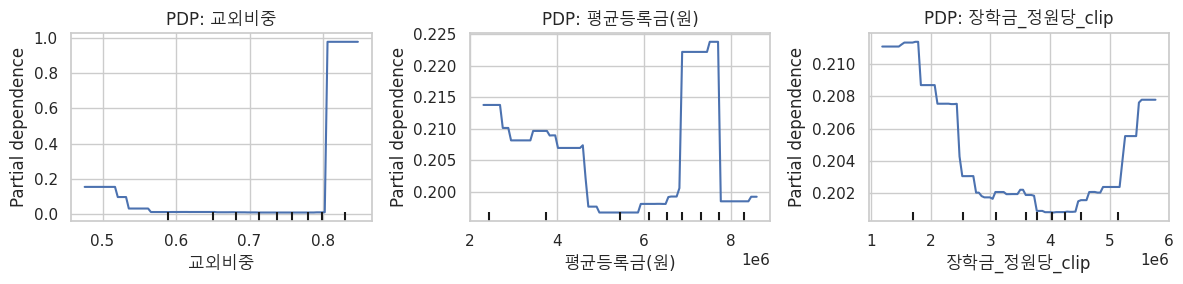

In [29]:
# PDP: 보정모델(cal) + Xi
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

targets = [c for c in ["교외비중","평균등록금(원)","장학금_정원당_clip"] if c in Xi.columns]
if not targets:
    print("※ PDP 대상 컬럼이 Xi에 없습니다. 대상 컬럼 유무를 확인하세요.")
else:
    fig, ax = plt.subplots(1, len(targets), figsize=(4*len(targets), 3))
    if len(targets) == 1:
        ax = [ax]
    for i, f in enumerate(targets):
        PartialDependenceDisplay.from_estimator(cal, Xi, [f], ax=ax[i], kind="average")
        ax[i].set_title(f"PDP: {f}")
    plt.tight_layout(); plt.show()


## 20-5. 특성 기여 검증(퍼뮤테이션 중요도; AUC drop)

In [30]:
# Permutation Importance: cal + Xi/yi
from sklearn.inspection import permutation_importance

r = permutation_importance(cal, Xi, yi, scoring="roc_auc",
                           n_repeats=30, random_state=42, n_jobs=-1)
imp_df = (pd.DataFrame({"feature": Xi.columns, "AUC_drop": r.importances_mean})
            .sort_values("AUC_drop", ascending=False)
            .head(20))
display(imp_df)

imp_df.to_csv("artifacts/top_features_permutation_auc_drop.csv",
              index=False, encoding="utf-8-sig")
print("saved → artifacts/top_features_permutation_auc_drop.csv")


,feature,AUC_drop
5,교외비중,3.616675e-01
0,평균등록금(원),7.437385e-04
10,설립별,4.068560e-04
1,총계(원),1.341759e-04
3,장학금_정원당_clip,1.320118e-04
2,입학정원,1.226339e-04
6,교내비중,1.154201e-05
4,장학금_등록금대비_clip,7.401487e-18
7,log_평균등록금(원),0.000000e+00
8,log_총계(원),0.000000e+00


saved → artifacts/top_features_permutation_auc_drop.csv


## 20-6. 정책 최적화(예산 내 최대 위험감소) — 그리디 추천

In [33]:
# 예산제약 하 효율 최대 추천 — 이름 컬럼 보정 포함
import numpy as np, pandas as pd, os

plan_path = "risk_action_plan_counterfactual.csv"
if not os.path.exists(plan_path):
    print("※ 'risk_action_plan_counterfactual.csv'가 없어 정책 추천을 건너뜁니다.")
else:
    action = pd.read_csv(plan_path)

    # === [핵심] 이름 컬럼 정리 ==========================
    # action 안에 어떤 이름 컬럼이 있는지 탐색: 학교명 > 대학명 > 대학키
    name_col = next((c for c in ["학교명", "대학명", "대학키"] if c in action.columns), None)

    # 만약 학교명이 없거나 NaN이 많으면 master에서 매핑으로 채움
    Mi = master.reset_index(drop=True)
    src_name = "학교명" if "학교명" in Mi.columns else ("대학명" if "대학명" in Mi.columns else "대학키")
    name_map = dict(zip(Mi["대학키"], Mi[src_name]))

    if name_col is None:
        # 정말로 아무 이름 컬럼이 없으면 대학키로부터 생성
        if "대학키" in action.columns:
            action["학교명"] = action["대학키"].map(name_map)
        else:
            action["학교명"] = np.nan
    else:
        if name_col != "학교명":
            action.rename(columns={name_col: "학교명"}, inplace=True)
        # 비어 있는 값은 대학키로 보완
        if "대학키" in action.columns:
            action["학교명"] = action["학교명"].fillna(action["대학키"].map(name_map))
    # ===================================================

    # gain/비용/효율 계산(그대로)
    for col in ["현재_prob","prob_after_교외비중","prob_after_정원당","추가_교내장학금(원)_대략"]:
        if col not in action.columns:
            action[col] = np.nan
    action["after_min"] = action[["prob_after_교외비중","prob_after_정원당"]].min(axis=1)
    action["gain"]      = action["현재_prob"] - action["after_min"]
    action["비용"]       = action["추가_교내장학금(원)_대략"].fillna(0)
    action["효율"]      = action["gain"] / (action["비용"] + 1)

    # 예산 하 그리디 선택
    B = 5_000_000_000  # 50억 (원하면 바꿔도 됨)
    picked, used = [], 0
    for _, r in action.sort_values("효율", ascending=False).iterrows():
        if r["비용"] <= 0 or np.isnan(r["비용"]):
            continue
        if used + r["비용"] <= B:
            picked.append(r)
            used += r["비용"]

    recs = (pd.DataFrame(picked)
              .loc[:, ["학교명","현재_prob","after_min","gain","비용","교외비중_delta","정원당_delta"]]
              .rename(columns={"비용":"추가_교내장학금(원)"}))

    # 보기/저장
    display(recs.head(20))
    os.makedirs("artifacts", exist_ok=True)
    recs.to_csv("artifacts/policy_pick_greedy.csv", index=False, encoding="utf-8-sig")
    print(f"[예산={B:,}] 사용액={used:,.0f}  → saved artifacts/policy_pick_greedy.csv")

,학교명,현재_prob,after_min,gain,추가_교내장학금(원),교외비중_delta,정원당_delta
14,한국폴리텍 II 대학 남인천캠퍼스,0.9967,0.003342,0.993358,292364.0,-0.004,NaN
12,한국폴리텍 V 대학 전남캠퍼스,0.9967,0.003342,0.993358,3001325.0,-0.014,NaN
28,한국폴리텍 특성화대학 로봇캠퍼스,0.9967,0.003342,0.993358,4539712.0,-0.024,NaN
31,한국폴리텍 VI 대학 영주캠퍼스,0.9967,0.003342,0.993358,5105528.0,-0.076,NaN
17,부산예술대학,0.9967,0.003184,0.993516,5874656.0,-0.002,NaN
16,순복음총회신학교,0.9967,0.004864,0.991836,7261520.0,-0.014,NaN
29,한국폴리텍 특성화대학 항공캠퍼스,0.9967,0.003342,0.993358,7971518.0,-0.018,NaN
19,한국폴리텍 III 대학 강릉캠퍼스,0.9967,0.003342,0.993358,8295617.0,-0.042,NaN
26,한국폴리텍 V 대학 익산캠퍼스,0.9967,0.003342,0.993358,8403800.0,-0.050,NaN
21,대전신학대학,0.9967,0.004864,0.991836,8527896.0,-0.032,NaN


[예산=5,000,000,000] 사용액=4,636,199,381  → saved artifacts/policy_pick_greedy.csv


## 20-7. 최종 스코어 + 리포트 표 저장

In [32]:
# 보정확률 기반 스코어보드: cal + Xi/yi + Mi
from sklearn.metrics import classification_report

p_cal = cal.predict_proba(Xi)[:, 1]
pred  = (p_cal >= thr_cal).astype(int)

board = Mi.copy()
board["prob_cal"] = p_cal
board["pred@thr"] = pred

os.makedirs("artifacts", exist_ok=True)
board.to_csv("artifacts/risk_scored_board_calibrated.csv", index=False, encoding="utf-8-sig")
print("saved → artifacts/risk_scored_board_calibrated.csv")

print(classification_report(yi, pred, digits=3, zero_division=0))


saved → artifacts/risk_scored_board_calibrated.csv
              precision    recall  f1-score   support

           0      1.000     0.951     0.975       304
           1      0.835     1.000     0.910        76

    accuracy                          0.961       380
   macro avg      0.918     0.975     0.942       380
weighted avg      0.967     0.961     0.962       380

